<a href="https://colab.research.google.com/github/alfrizzle/MSDS-453/blob/master/YI_ALFRED_MSDS453_Assignment_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSDS 453: Research/Programming Assignment #3

## Preparing Environment

In [ ]:
!pip install jsonlines

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from google.colab import files

import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from collections import namedtuple
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import utils
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import json
import jsonlines
import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
import pickle
import string
import re
import math
import seaborn as sns
import multiprocessing
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patheffects as PathEffects
import pprint
pp = pprint.PrettyPrinter(indent=4)
% matplotlib inline

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
!mkdir -p abc
!echo "file" > abc/123.txt
!ls

abc  drive  sample_data


In [ ]:
import os
os.chdir('/content/drive/My Drive/MSDS 453/Assignment 3')

# Now the directory 'abc' is the current working directory.
!ls

abc		       term_hierarachy.png
d2v_doc_clusters.png   tfidf_document_clusters.png
doc_cluster.pkl        tfidf_term_hierarachy.png
document_clusters.png  YI_ALFRED_MSDS453_Assignment_03
scitech_articles.jl    Yi_Alfred_MSDS453_Assignment_03_Files
term_clusters.png


Reading in corpus (this is the same corpus generated from assignment #1)

In [ ]:
# PATH = '/content/drive/My Drive/MSDS 453/Data/News_Category_Dataset_v2.json'
PATH = '/content/drive/My Drive/MSDS 453/Assignment 3/scitech_articles.jl'

In [ ]:
scitechcorpus = []

with open(PATH) as fr:
    for line in fr.readlines():
        row_obj = json.loads(line)
        scitechcorpus.append(row_obj)


In [ ]:
scitechcorpus[0]

{'Body': 'WASHINGTON (Reuters) - The Trump administration plans to unveil efforts on Friday to crack down on counterfeit and pirated goods sold on major e-commerce sites and urge companies to do more to vet third-party sellers and increase self-policing efforts. Acting Department of Homeland Security Secretary Chad Wolf and White House adviser Peter Navarro will be among officials at a news conference on Friday to discuss the effort at the National Intellectual Property Rights Coordination Center in Arlington, Virginia, administration officials said on Thursday. Foreign sellers face little risk of prosecution, an administration official told Reuters, so strong U.S. government action “is necessary to fundamentally realign incentive structures.” Law enforcement agencies are planning “immediate actions” to identify counterfeit goods and seek “all available statutory authorities to pursue civil fines and other penalties against these entities,” according to a DHS report reported by the Wal

## Data Exploration

Creating dataframe for easier viewing and data exploration

In [ ]:
# df = pd.DataFrame(data=container, columns=["category", "headline", "authors", "link", "short_description", "date"])
df = pd.DataFrame(data = scitechcorpus, columns = ['ID', 'PublishDate', 'Source', 'Topic', 'Title', 'Body', 'URL'])

In [ ]:
#List unique values in the df['XXX'] column
df.Source.unique()

array(['www.reuters.com', 'www.npr.org', 'The Tribune Online',
       'Deccan Herald Online', 'The Times of Israel',
       'The Times of India Online', 'The Hindu Online', 'oneindia',
       'Ministry of Foreign Affairs', 'Business Standard Online',
       'Haaretz.com', 'The Jerusalem Post Online',
       'The Economic Times Online', 'Business Line Online',
       'The Financial Express Online', 'The Express Tribune Online',
       'Mail Today (Electronic Edition)', 'Weizmann Institute of Science',
       'The Nation Online', 'Associated Press of Pakistan Online',
       'Dawn Online', 'Ben-Gurion University of the Negev', 'Quwa Online',
       'Hindustan Times Online', 'Israel Defense Online', 'CTech',
       'ThePrint Online', 'Bhabha Atomic Research Centre', 'Technion',
       'NDTV Online', 'The New Indian Express Online', 'Livemint Online',
       'Daily News and Analysis Online', 'The Pioneer Online',
       'AMOS Spacecom', 'The Indian Express', 'Radio Pakistan Online',
      

In [ ]:
len(df.Source.unique())

62

In [ ]:
# renaming source names that are a URL
df["Source"]= df["Source"].str.replace("www.reuters.com", "Reuters", case = True) 
df["Source"]= df["Source"].str.replace("www.npr.org", "NPR", case = True) 
df["Source"]= df["Source"].str.replace("www.calcalistech.com", "CTech", case = True) 

# # creating a filter for age column  
# # where age = "Twenty five"  
# filter = data["Team"]=="New Boston Celtics"
  
# # printing only filtered columns  
# data.where(filter).dropna() 

Confirming URLs have been successfully replaced with new source names

In [ ]:
#To select rows whose column value is in list 
sourcelist = ['Reuters', 'NPR', 'CTech']
filter = df.loc[df['Source'].isin(sourcelist)]
filter

ID  ...                                                URL
0      1.0  ...  https://www.reuters.com/article/us-usa-trump-c...
1      2.0  ...  https://www.reuters.com/article/us-uber-self-d...
2      3.0  ...  https://www.reuters.com/article/us-germany-bol...
3      4.0  ...  https://www.npr.org/2020/01/23/798630195/dont-...
4      5.0  ...  https://www.npr.org/sections/goatsandsoda/2019...
5      6.0  ...  https://www.npr.org/2019/12/11/786760790/44-00...
6      7.0  ...  https://www.npr.org/sections/health-shots/2020...
7      8.0  ...  https://www.npr.org/sections/thesalt/2020/01/2...
8      9.0  ...  https://www.npr.org/2020/01/09/795017172/2020-...
9     10.0  ...  https://www.reuters.com/article/us-il-aerospac...
10    11.0  ...  https://www.reuters.com/article/us-tech-ces-li...
11    12.0  ...  https://www.reuters.com/article/us-china-scien...
12    13.0  ...  https://www.reuters.com/article/us-health-auti...
13    14.0  ...  https://www.reuters.com/article/us-japan-billi...
14    15.0  ...  https://www.reuters.com/article/us-science-mic...
15    16.0  ...  https://www.reuters.com/article/us-france-tech...
16    17.0  ...  https://www.reuters.com/article/us-space-explo...
17    18.0  ...  https://www.reuters.com/article/uk-britain-eu-...
18    19.0  ...  https://www.reuters.com/article/us-space-explo...
19    20.0  ...  https://www.reuters.com/article/us-russia-cosm...
67    68.0  ...  https://www.calcalistech.com/ctech/articles/0,...
70    71.0  ...  https://www.calcalistech.com/ctech/articles/0,...
78    80.0  ...  https://www.calcalistech.com/ctech/articles/0,...
85    87.0  ...  https://www.calcalistech.com/ctech/articles/0,...
86    88.0  ...  https://www.calcalistech.com/ctech/articles/0,...
87    89.0  ...  https://www.calcalistech.com/ctech/articles/0,...
108  111.0  ...  https://www.calcalistech.com/ctech/articles/0,...
109  112.0  ...  https://www.calcalistech.com/ctech/articles/0,...
110  113.0  ...  https://www.calcalistech.com/ctech/articles/0,...
114  117.0  ...  https://www.calcalistech.com/ctech/articles/0,...
129  132.0  ...  https://www.calcalistech.com/ctech/articles/0,...
132  136.0  ...  https://www.calcalistech.com/ctech/articles/0,...
133  137.0  ...  https://www.calcalistech.com/ctech/articles/0,...
135  139.0  ...  https://www.calcalistech.com/ctech/articles/0,...
173  177.0  ...  https://www.calcalistech.com/ctech/articles/0,...
174  178.0  ...  https://www.calcalistech.com/ctech/articles/0,...
175  179.0  ...  https://www.calcalistech.com/ctech/articles/0,...
222  226.0  ...  https://www.calcalistech.com/ctech/articles/0,...
223  227.0  ...  https://www.calcalistech.com/ctech/articles/0,...
226  231.0  ...  https://www.calcalistech.com/ctech/articles/0,...
298  303.0  ...  https://www.calcalistech.com/ctech/articles/0,...
300  305.0  ...  https://www.calcalistech.com/ctech/articles/0,...
329  334.0  ...  https://www.calcalistech.com/ctech/articles/0,...
374  379.0  ...  https://www.calcalistech.com/ctech/articles/0,...
375  380.0  ...  https://www.calcalistech.com/ctech/articles/0,...
376  381.0  ...  https://www.calcalistech.com/ctech/articles/0,...
377  382.0  ...  https://www.calcalistech.com/ctech/articles/0,...
379  384.0  ...  https://www.calcalistech.com/ctech/articles/0,...
409  414.0  ...  https://www.calcalistech.com/ctech/articles/0,...
423  428.0  ...  https://www.calcalistech.com/ctech/articles/0,...
426  431.0  ...  https://www.calcalistech.com/ctech/articles/0,...
429  435.0  ...  https://www.calcalistech.com/ctech/articles/0,...
430  436.0  ...  https://www.calcalistech.com/ctech/articles/0,...
432  438.0  ...  https://www.calcalistech.com/ctech/articles/0,...
439  445.0  ...  https://www.calcalistech.com/ctech/articles/0,...
441  447.0  ...  https://www.calcalistech.com/ctech/articles/0,...
446  452.0  ...  https://www.calcalistech.com/ctech/articles/0,...
447  453.0  ...  https://www.calcalistech.com/ctech/articles/0,...

[58 rows x 7 columns]

Quick check on body contents using handy module I can use to wrap long text





In [ ]:
import textwrap 

In [ ]:
# Wrap this text. 
wrapper = textwrap.TextWrapper(width=70) 
  
# word_list = wrapper.wrap(text=value) 
  
# # Print each line. 
# for element in word_list: 
#     print(element) 

In [ ]:
wrapper.wrap(df['Body'][10])

['DETROIT/LAS VEGAS (Reuters) - Self-driving cars employ lidar, a remote',
 'sensing technology using pulsed laser light the way radar uses radio',
 'waves, and lidar makers waiting for the automotive market to take off',
 'are courting new customers who would use the technology for everything',
 'from monitoring cattle to helping a disc jockey synchronize dance',
 'music. Ouster, a San Francisco tech startup, is tapping new markets',
 'including delivery robots, disaster relief and even an approach from',
 'the disc jockey. Another Bay area startup, AEye, is talking to a bank',
 'that wants to monitor cattle growth to ensure the financial health of',
 'a rancher who is a loan customer. Alternative uses and customers are',
 'needed to keep revenue flowing at lidar startups waiting for the',
 'expected boom in self-driving cars, which still looks to be years',
 'away. “We never took an exclusively automotive view of lidar,” said',
 'Angus Pacala, Ouster chief executive and co-founder. “

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
ID             499 non-null float64
PublishDate    499 non-null object
Source         499 non-null object
Topic          499 non-null object
Title          499 non-null object
Body           499 non-null object
URL            499 non-null object
dtypes: float64(1), object(6)
memory usage: 27.4+ KB


In [ ]:
df.isnull().sum()

ID             0
PublishDate    0
Source         0
Topic          0
Title          0
Body           0
URL            0
dtype: int64

Creating dict keys for all topics in corpus

In [ ]:
topics, topic_data = df['Topic'].unique().tolist(), dict()

for topic in topics:
    topic_data["df_{}".format(topic.lower().replace(" ", ""))] = df[(df['Topic'] == topic)]
    
topic_data.keys()

dict_keys(['df_proliferation', 'df_ai', 'df_energy', 'df_cyber', 'df_health', 'df_tech', 'df_bio', 'df_environment', 'df_space', 'df_weapons', 'df_aeronautics', 'df_nuclear', 'df_chem', 'df_robotics', 'df_pharmacology'])

In [ ]:
df['Topic'].value_counts().sort_values(ascending=False).plot.bar

<bound method PlotAccessor.bar of <pandas.plotting._core.PlotAccessor object at 0x7f6dd4e73f98>>

Text(0, 0.5, 'Number of Articles')

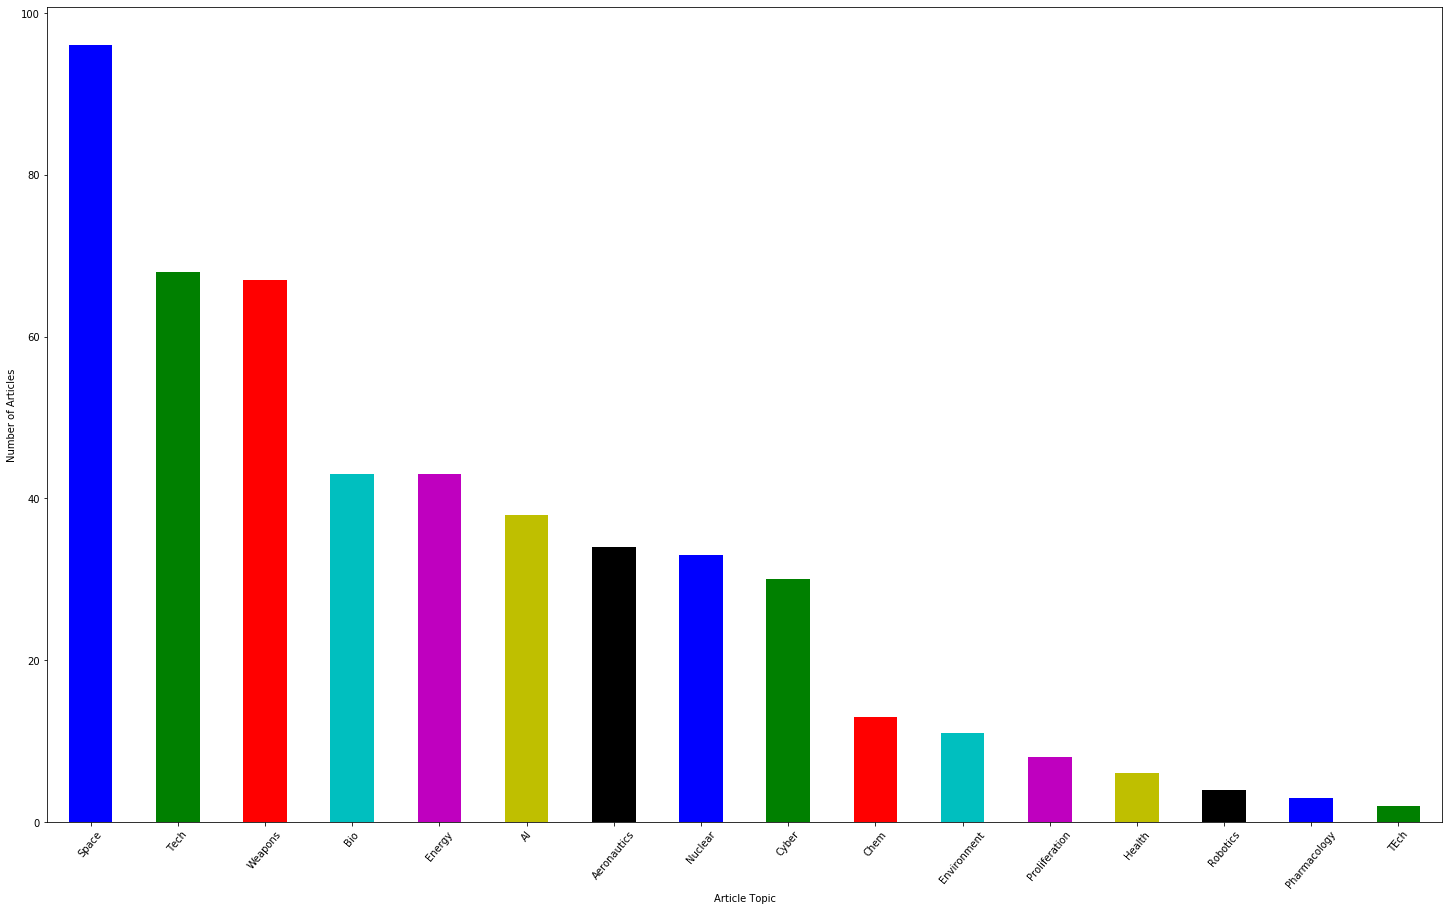

In [ ]:
plt.figure(figsize=(25,15))
cmapper = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
df['Topic'].value_counts().sort_values(ascending=False).plot.bar(color=cmapper)
plt.xticks(rotation=50)
plt.xlabel("Article Topic")
plt.ylabel("Number of Articles")

Noticed there are a couple of items under a "TEch" topic (wrong case). I'll look up the rows with the incorrect case and replace them with "Tech"

In [ ]:
df.loc[df['Topic'] == 'TEch']

ID  ...                                                URL
362  367.0  ...                        timesofindia.indiatimes.com
428  434.0  ...  http://in.bgu.ac.il/en/pages/news/bullguard_bg...

[2 rows x 7 columns]

In [ ]:
# correcting case
df["Topic"]= df["Topic"].str.replace("TEch", "Tech", case = True)

In [ ]:
# confirming that the issue was resolved
df.loc[df['Topic'] == 'TEch']

Empty DataFrame
Columns: [ID, PublishDate, Source, Topic, Title, Body, URL]
Index: []

Text(0, 0.5, 'Number of Articles')

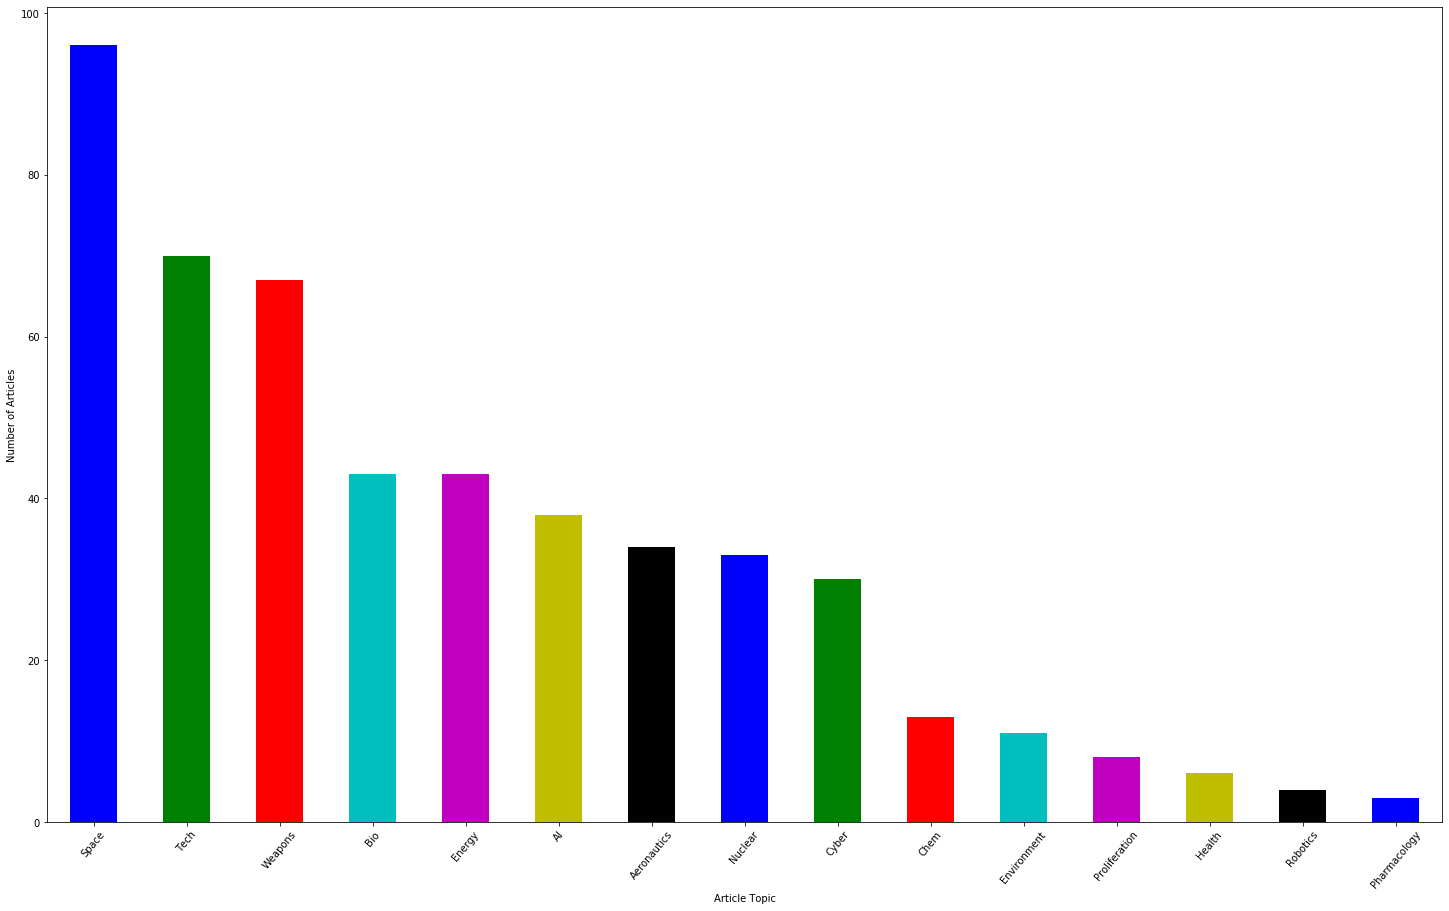

In [ ]:
plt.figure(figsize=(25,15))
cmapper = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
df['Topic'].value_counts().sort_values(ascending=False).plot.bar(color=cmapper)
plt.xticks(rotation=50)
plt.xlabel("Article Topic")
plt.ylabel("Number of Articles")

In [ ]:
df.Topic.unique()

array(['Proliferation', 'AI', 'Energy', 'Cyber', 'Health', 'Tech', 'Bio',
       'Environment', 'Space', 'Weapons', 'Aeronautics', 'Nuclear',
       'Chem', 'Robotics', 'Pharmacology'], dtype=object)

In [ ]:
topic_count = len(df.Topic.unique())
print('Total # of topics:', topic_count)

Total # of topics: 15


In [ ]:
df['Topic'].value_counts()

Space            96
Tech             70
Weapons          67
Energy           43
Bio              43
AI               38
Aeronautics      34
Nuclear          33
Cyber            30
Chem             13
Environment      11
Proliferation     8
Health            6
Robotics          4
Pharmacology      3
Name: Topic, dtype: int64

## Tokenization

In [ ]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

Two Functions:

*   **tokenize_and_stem**: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token
*   **tokenize_only**: tokenizes the synopsis only

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes.

In [ ]:
# tokenizer and stemmer that returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Tokenization method from Brownlee Ch.5

In [ ]:
# # split into words
# tokens = word_tokenize(text)
# # convert to lower case
# tokens = [w.lower() for w in tokens]
# # prepare regex for char filtering
# re_punc = re.compile('[%s]' % re.escape(string.punctuation))
# # remove punctuation from each word
# stripped = [re_punc.sub('', w) for w in tokens]
# # remove remaining tokens that are not alphabetic
# words = [word for word in stripped if word.isalpha()]
# # filter out stop words
# stop_words = set(stopwords.words('english'))
# words = [w for w in words if not w in stop_words]

In [ ]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    # stop_words = set(stopwords.words('english'))
    stop_words = STOPWORDS
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

Resetting "topics" variable to account for the case correction above

In [ ]:
topics, topic_data = df['Topic'].unique().tolist(), dict()

for topic in topics:
    topic_data["df_{}".format(topic.lower().replace(" ", ""))] = df[(df['Topic'] == topic)]
    
topic_data.keys()

dict_keys(['df_proliferation', 'df_ai', 'df_energy', 'df_cyber', 'df_health', 'df_tech', 'df_bio', 'df_environment', 'df_space', 'df_weapons', 'df_aeronautics', 'df_nuclear', 'df_chem', 'df_robotics', 'df_pharmacology'])

In [ ]:
df.Body

0      WASHINGTON (Reuters) - The Trump administratio...
1      WASHINGTON (Reuters) - Uber Technologies Inc (...
2      BERLIN (Reuters) - Germany will seek talks wit...
3      The phone of Jeff Bezos allegedly was hacked v...
4      A blood transfusion bag hangs in an operating ...
                             ...                        
494    "Atom bomb" redirects here. For other uses, se...
495    This article needs additional citations for ve...
496    This article is about guided missiles. For ung...
497    "Roboticist" redirects here. It is not to be c...
498    "AI" redirects here. For other uses, see AI (d...
Name: Body, Length: 499, dtype: object

### Note on parameters for vectorization methods

A couple things to note about the parameters for the following document vectorization methods:

*   **max_df**: this is the maximum frequency within the documents a given feature can have to be used in the matrix. If the term is in greater than 80% of the documents it probably carries little meaning (in the context of the article)
*  **min_idf**: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
*   **ngram_range**: this just means I'll look at unigrams, bigrams and trigrams. See n-grams 

**Alternative Explanation**

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:

*   max_df = 0.50 means "ignore terms that appear in more than 50% of the  documents".
*   max_df = 25 means "ignore terms that appear in more than 25 documents".

The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

**min_df** is used for removing terms that appear too infrequently. For example:

*   min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
*   min_df = 5 means "ignore terms that appear in less than 5 documents".

The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.


Turning Column Values to List for Easier Data Manipulation

In [ ]:
df.columns

Index(['ID', 'PublishDate', 'Source', 'Topic', 'Title', 'Body', 'URL'], dtype='object')

In [ ]:
ID = df.ID.tolist()
titles = df.Title.tolist()
sources = df.Source.tolist()
topics = df.Topic.tolist()
body = df.Body.tolist()

## Approach #1: Analyst Judgment

Using CountVectorizer() to analyze term frequency in corpus's body text

In [ ]:
# Count Vectorizer for entire model 

# cvector = CountVectorizer(max_df=0.8, max_features=200000,
#                                  min_df=0.2, stop_words=stopwords,
#                                  tokenizer = tokenize_only, ngram_range=(1,2))

cvector = CountVectorizer(min_df = 0.2, max_df = 0.8, ngram_range=(1,2), stop_words = STOPWORDS,
                          tokenizer = clean_doc)
cvector_matrix = cvector.fit_transform(body) #fit the vectorizer to text in articles

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'hadnt', 'hasnt', 'havent', 'heres', 'mustnt', 'shant', 'shell', 'shouldnt', 'thats', 'theres', 'theyd', 'theyll', 'theyre', 'theyve', 'wasnt', 'werent', 'whats', 'whens', 'wheres', 'wouldnt', 'youll', 'youre', 'youve'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
cvector_matrix.shape

(499, 98)

In [ ]:
len(cvector.get_feature_names())

98

In [ ]:
cvector_terms = cvector.get_feature_names()

In [ ]:
list(cvector.vocabulary_.keys())[:50]

['major',
 'companies',
 'security',
 'among',
 'national',
 'strong',
 'government',
 'according',
 'report',
 'online',
 'information',
 'united',
 'states',
 'better',
 'global',
 'including',
 'group',
 'china',
 'united states',
 'company',
 'support',
 'development',
 'first',
 'three',
 'using',
 'technology',
 'second',
 'industry',
 'country',
 'production',
 'years',
 'systems',
 'another',
 'project',
 'ministry',
 'agency',
 'science',
 'research',
 'generally',
 'system',
 'countries',
 'critical',
 'daily',
 'published',
 'world',
 'institute',
 'south',
 'times',
 'added',
 'million']

In [ ]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in body:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [ ]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('There are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

There are 379091 items in vocab_frame


In [ ]:
vocab_frame.head()

words
washington      washington
reuter             reuters
the                    the
trump                trump
administr   administration

### Document-Term Matrix (Analyst Judgment)

In [ ]:
cvector_array = cvector_matrix.toarray()
cvector_array

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 4, 1],
       [1, 0, 3, ..., 3, 0, 0],
       [3, 0, 1, ..., 3, 6, 3]])

In [ ]:
df_cvector = pd.DataFrame(cvector_array, columns = cvector_terms)
df_cvector.head(10)

according  added  advanced  agency  ...  website  within  world  years
0          1      0         0       0  ...        0       0      0      0
1          0      0         0       0  ...        0       0      0      0
2          1      0         0       1  ...        0       0      0      1
3          0      0         0       0  ...        0       0      0      2
4          1      1         0       0  ...        0       0      2      0
5          0      0         0       0  ...        0       0      0      7
6          0      0         0       0  ...        0       0      0      0
7          1      0         0       0  ...        0       0      1      1
8          0      0         0       0  ...        0       0      0      0
9          0      0         0       0  ...        0       0      0      2

[10 rows x 98 columns]

### Term Frequency Sorted

Function to generate top n words in corpus by frequency

In [ ]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer(min_df = 0.2, max_df = 0.8, ngram_range=(1,2), stop_words = STOPWORDS).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
cvector_top20 = get_top_n_words(body, 20)
for word, freq in cvector_top20:
    print(word, freq)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


india 1460
will 1363
technology 1273
research 1152
science 1133
said 1095
pakistan 889
new 875
first 869
english 771
space 755
government 684
daily 683
development 665
url 658
indian 590
one 584
center 556
left 549
top 547


In [ ]:
# converting top 20 terms into dataframe
df_cvranking = pd.DataFrame(cvector_top20, columns = ['Term', 'Count'])
df_cvranking

Term  Count
0         india   1460
1          will   1363
2    technology   1273
3      research   1152
4       science   1133
5          said   1095
6      pakistan    889
7           new    875
8         first    869
9       english    771
10        space    755
11   government    684
12        daily    683
13  development    665
14          url    658
15       indian    590
16          one    584
17       center    556
18         left    549
19          top    547

In [ ]:
def create_tf_matrix(topic):
    return cvector.transform(df[df['Topic'] == topic].Body)

In [ ]:
topic_data.keys()

dict_keys(['df_proliferation', 'df_ai', 'df_energy', 'df_cyber', 'df_health', 'df_tech', 'df_bio', 'df_environment', 'df_space', 'df_weapons', 'df_aeronautics', 'df_nuclear', 'df_chem', 'df_robotics', 'df_pharmacology'])

### Document Clustering

#### Determining Number of Clusters

In [ ]:
km = KMeans(n_clusters=6, init='k-means++', random_state=5)
km.fit(cvector_matrix)
km.inertia_

105687.5387223771

Text(0, 0.5, 'Inertia')

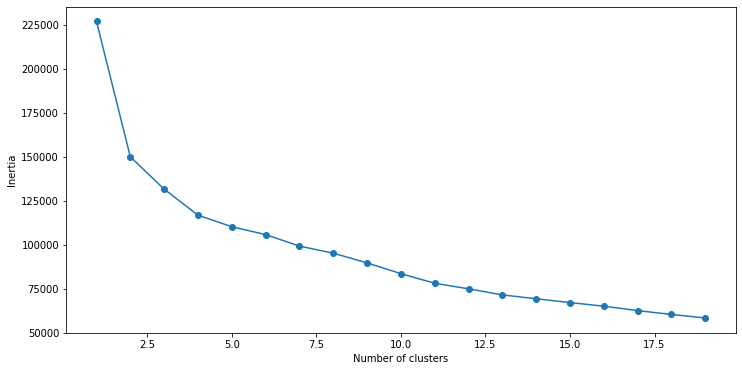

In [ ]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    km = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++', random_state=5)
    km.fit(cvector_matrix)
    SSE.append(km.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
# k means using 6 clusters and k-means++ initialization
kmeans = KMeans(n_jobs = -1, n_clusters = 6, init='k-means++', random_state=5)
kmeans.fit(cvector_matrix)
pred = kmeans.predict(cvector_matrix)

frame = pd.DataFrame(cvector_matrix)
frame['cluster'] = pred
frame['cluster'].value_counts()

4    391
0     89
2     13
1      3
5      2
3      1
Name: cluster, dtype: int64

#### Summary of documents by cluster

In [ ]:
# creating variables to quickly filter documents in each cluster

cluster_0 = df.loc[frame['cluster'] == 0]
cluster_1 = df.loc[frame['cluster'] == 1]
cluster_2 = df.loc[frame['cluster'] == 2]
cluster_3 = df.loc[frame['cluster'] == 3]
cluster_4 = df.loc[frame['cluster'] == 4]
cluster_5 = df.loc[frame['cluster'] == 5]

Filtering document with corresponding Topic and Title columns to get a general picture of contents

In [ ]:
cluster_0[['Topic', 'Title']].head(10)

Topic                                              Title
24    Space  Indian Premier Space Agency ISRO To Design, De...
29  Nuclear  India: DRDO Successfully Test-Fires 'Indigenou...
30    Space  Indian Government Approves ISRO To Develop Sem...
32    Space  India: With Eye on China, Mauritius Seeks Help...
35    Space  India: Space Research Agency Creating 'Consort...
37  Weapons  India: Process Begins To Induct First Intercon...
45    Cyber  India: National Informatics Center Says Hardwa...
46    Space  India: ISRO Chief Says Space Agency Knows 'Exa...
55    Space  Revision: India: ISRO Chairman Says Heaviest S...
65  Weapons  India, Russia Sign $500 Million Navy Deal To B...

In [ ]:
cluster_1[['Topic', 'Title']].head(10)

Topic                                        Title
457     Tech  Science and technology in the United States
489  Nuclear                        Nuclear proliferation
494  Nuclear                               Nuclear weapon

In [ ]:
cluster_2[['Topic', 'Title']].head(10)

Topic                                        Title
449  Tech               Science and technology studies
450  Tech              Science and technology in China
451  Tech              Science and technology in India
453  Tech             Science and technology in Israel
454  Tech               Science and technology in Iran
455  Tech           Science and technology in Pakistan
458  Tech             Science and technology in Brazil
466  Tech  History of science and technology in Mexico
472  Tech    Science and technology in the Philippines
476  Tech           Science and technology in Tanzania

In [ ]:
cluster_3[['Topic', 'Title']].head(10)

Topic                              Title
471  Tech  History of science and technology

In [ ]:
cluster_4[['Topic', 'Title']].head(10)

Topic                                              Title
0  Proliferation  U.S. to unveil crackdown on counterfeit, pirat...
1             AI  Uber self-driving cars, with humans in control...
2         Energy  Germany to urge next Bolivian leaders to reviv...
3          Cyber  Don't Be Like Jeff Bezos. Here's How To Keep Y...
4         Health  Hospitals Around The World Have A Dire Shortag...
5           Tech  44,000-Year-Old Indonesian Cave Painting Is Re...
6         Health  Hope, Happiness And Social Connection: Hidden ...
7            Bio  Ready For Meat Grown From Animal Cells? A Star...
8    Environment             2020 So Far: Fires, Floods, And Quakes
9          Space  Israel Aerospace to build Israel's next commun...

In [ ]:
cluster_5[['Topic', 'Title']].head(10)

Topic        Title
486  Space    Satellite
487  Space  Spaceflight

#### Top Keywords

In [ ]:
num_clusters = 6
km = KMeans(n_clusters=num_clusters, random_state=5)
km.fit(cvector_matrix)
clusters = km.labels_.tolist()

docs = { 'ID': ID, 'title': titles, 'source': sources, 'topic': topics, 'cluster': clusters, 'body': body }
docs_frame = pd.DataFrame(docs, index = [clusters] , columns = ['ID', 'title', 'cluster', 'topic'])
docs_frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

clusters_mini = MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=5).fit_predict(cvector_matrix)
# clusters = MiniBatchKMeans(n_clusters=4, random_state=20).fit_predict(cvector_matrix)

In [ ]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

In [ ]:
from __future__ import print_function

print("Top terms per cluster:")

get_top_keywords(cvector_matrix, clusters_mini, cvector_terms, 20)
print()

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

print("Top titles per cluster:")
print()
for i in range(num_clusters):
    # print("Cluster %d words:" % i, end='')
    
    # for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
    #     print(' %s' % vocab_frame.loc[cvector_terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    # print() #add whitespace
    # print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in docs_frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0
world,country,government,science,national,system,development,production,international,research,states,technology,india,south,pakistan,united,first,project,power,energy

Cluster 1
science,system,systems,development,government,company,online english,website,million,source,defense,online,english,first,indian,daily,pakistan,technology,india,research

Cluster 2
information,world,international,million,institute,companies,countries,country,india,pakistan,economic,china,policy,first,government,national,development,research,technology,science

Cluster 3
independent,various,including,information,united,international,group,world,major,first,country,several,india,policy,development,within,research,institute,technology,science

Cluster 4
website,china,source,government,research,issues,englishlanguage,first,critical,mumbai,economic,indian,online english,online,english,launch,daily,space,times,india

Cluster 5
including,systems,system,military,india,development,power

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(cvector_matrix)

#### MDS with t-SNE

In [ ]:
tsne = TSNE(n_components=2, random_state=5)
cvector_tsne = tsne.fit_transform(dist)
xs, ys = cvector_tsne[:, 0], cvector_tsne[:, 1]

#### Visualizing Document Clusters

In [ ]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
cvector_plot_clusters = pd.DataFrame(dict(x=xs, y=ys, label=clusters, ID = ID)) 
cvector_plot_clusters

x          y  label     ID
0    -9.928561  12.157607      4    1.0
1   -13.703047  15.356766      4    2.0
2   -11.107125  13.592480      4    3.0
3   -19.794949  14.228848      4    4.0
4   -13.996540   9.035762      4    5.0
..         ...        ...    ...    ...
494 -11.255926   3.989701      1  500.0
495 -12.901896   9.197740      4  501.0
496  -7.449543   5.109342      4  502.0
497 -16.955612   1.550991      4  503.0
498 -26.052080   7.578295      4  504.0

[499 rows x 4 columns]

In [ ]:
# set up colors per clusters using a dict
cluster_colors = {0: '#ffff4d', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#1e9ba6', 5: '#8d1b9e'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3', 
                 4: 'Cluster 4',
                 5: 'Cluster 5'}

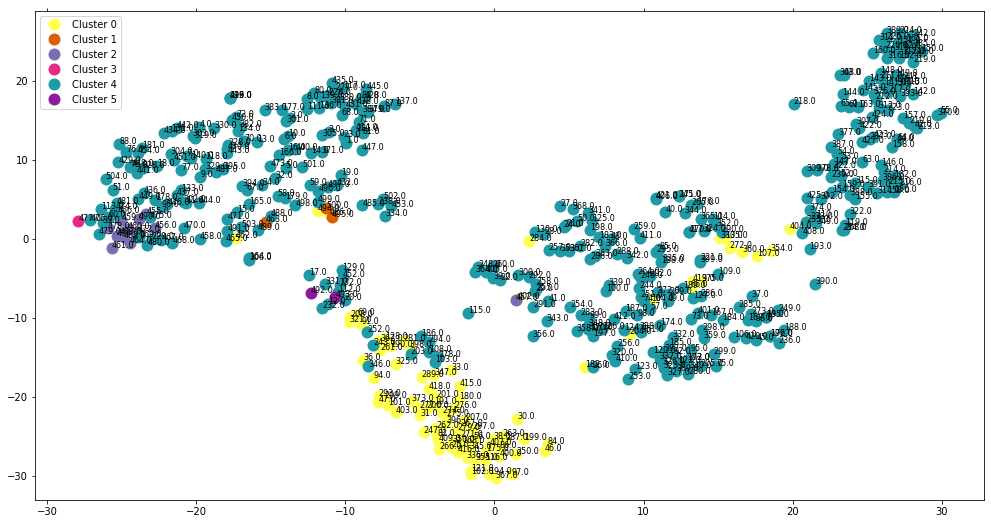

<Figure size 432x288 with 0 Axes>

In [ ]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
cvector_plot_clusters = pd.DataFrame(dict(x=xs, y=ys, label=clusters, ID = ID)) 

#group by cluster
groups = cvector_plot_clusters.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the title
for i in range(len(cvector_plot_clusters)):
    ax.text(cvector_plot_clusters.loc[i]['x'], cvector_plot_clusters.loc[i]['y'], cvector_plot_clusters.iloc[i]['ID'], size=8)  
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('document_clusters.png') 

In [ ]:
plt.close()

### Term Clustering

In [ ]:
df_cvector_transposed = df_cvector.T
df_cvector_terms = df_cvector_transposed

In [ ]:
df_cvector_terms.head(10)

0    1    2    3    4    5    6    ...  492  493  494  495  496  497  498
according    1    0    1    0    1    0    0  ...    1    3    1    1    0    1    3
added        0    0    0    0    1    0    0  ...    0    0    0    0    0    0    0
advanced     0    0    0    0    0    0    0  ...    4    0    1    0    1    3    1
agency       0    0    1    0    0    0    0  ...    0    5    2    0    1    0    0
among        1    0    0    0    1    1    3  ...    1    1    3    0    1    0    2
another      0    0    1    0    0    1    1  ...    1    0    5    0    3    3    1
areas        0    0    0    0    0    0    0  ...    0    0    2    3    0    1    2
better       1    0    1    0    0    0    0  ...    0    0    0    0    0    4    2
business     0    0    0    0    0    0    0  ...    0    0    0    0    0    0    2
china        1    0    1    0    1    0    0  ...    1    0    2    0    1    0    1

[10 rows x 499 columns]

In [ ]:
cvector_words = df_cvector_terms.index.tolist()

In [ ]:
km_terms = KMeans(n_clusters=6, init='k-means++', random_state=5)
km_terms.fit(df_cvector_terms)
km_terms.inertia_

95292.21141975308

#### Determining Number of Clusters

Text(0, 0.5, 'Inertia')

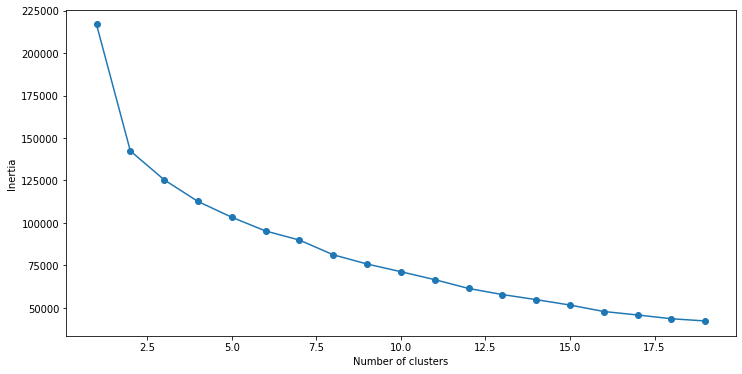

In [ ]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    km_terms = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++', random_state=5)
    km_terms.fit(df_cvector_terms)
    SSE.append(km_terms.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
# k means using 6 clusters and k-means++ initialization
km_terms = KMeans(n_jobs = -1, n_clusters = 6, init='k-means++', random_state=5)
km_terms.fit(df_cvector_terms)
pred_terms = km_terms.predict(df_cvector_terms)

frame = pd.DataFrame(df_cvector_terms)
frame['cluster'] = pred_terms
frame['cluster'].value_counts()

3    81
2     8
4     3
0     3
1     2
5     1
Name: cluster, dtype: int64

#### Summary of Terms by Cluster

In [ ]:
# creating variables to quickly filter documents in each cluster
cluster_0 = df_cvector_terms.loc[frame['cluster'] == 0]
cluster_1 = df_cvector_terms.loc[frame['cluster'] == 1]
cluster_2 = df_cvector_terms.loc[frame['cluster'] == 2]
cluster_3 = df_cvector_terms.loc[frame['cluster'] == 3]
cluster_4 = df_cvector_terms.loc[frame['cluster'] == 4]
cluster_5 = df_cvector_terms.loc[frame['cluster'] == 5]

In [ ]:
list(cluster_0.index.values)

['development', 'government', 'national']

In [ ]:
list(cluster_1.index.values)

['science', 'technology']

In [ ]:
list(cluster_2.index.values)

['countries',
 'energy',
 'international',
 'pakistan',
 'states',
 'united',
 'united states',
 'world']

In [ ]:
list(cluster_3.index.values)

['according',
 'added',
 'advanced',
 'agency',
 'among',
 'another',
 'areas',
 'better',
 'business',
 'china',
 'companies',
 'company',
 'country',
 'critical',
 'daily',
 'defense',
 'delhi',
 'description',
 'description source',
 'descriptor',
 'developed',
 'domestic',
 'economic',
 'english',
 'english website',
 'englishlanguage',
 'englishlanguage daily',
 'generally',
 'global',
 'group',
 'group publishes',
 'including',
 'independent',
 'india',
 'indian',
 'indias',
 'industry',
 'information',
 'institute',
 'islamabad',
 'issues',
 'known',
 'leading',
 'major',
 'military',
 'million',
 'minister',
 'ministry',
 'mumbai',
 'occasionally',
 'occasionally critical',
 'online',
 'online english',
 'policy',
 'power',
 'production',
 'project',
 'provide',
 'published',
 'publishes',
 'range',
 'report',
 'second',
 'security',
 'several',
 'source',
 'source descriptor',
 'south',
 'strong',
 'support',
 'supports',
 'system',
 'systems',
 'though',
 'three',
 'times',
 

In [ ]:
list(cluster_4.index.values)

['first', 'launch', 'space']

In [ ]:
list(cluster_5.index.values)

['research']

#### MDS with t-SNE

In [ ]:
dist_terms = 1 - cosine_similarity(df_cvector_terms)

tsne = TSNE(n_components=2, random_state=5)
cvector_terms_tsne = tsne.fit_transform(dist_terms)
xs, ys = cvector_terms_tsne[:, 0], cvector_terms_tsne[:, 1]

#### Visualizing Term Clusters

In [ ]:
term_clusters = km_terms.labels_.tolist()

In [ ]:
#create data frame that has the result of the MDS plus the cluster numbers and words
cvector_plot_clusters_terms = pd.DataFrame(dict(x=xs, y=ys, label=term_clusters, words = cvector_words)) 

In [ ]:
cvector_plot_clusters_terms

x         y  label      words
0   1.315544 -0.924692      3  according
1  -2.741735  2.233343      3      added
2   0.530278  1.024711      3   advanced
3   1.438951  3.486644      3     agency
4   4.254289 -0.693854      3      among
..       ...       ...    ...        ...
93  3.725292  1.821622      3    various
94 -9.008769  1.865304      3    website
95  4.271589  0.441230      3     within
96  5.025278  0.082756      2      world
97  4.064544 -0.978008      3      years

[98 rows x 4 columns]

In [ ]:
#set up cluster names using a dict
term_cluster_names = {0: 'Cluster 0', 
                      1: 'Cluster 1', 
                      2: 'Cluster 2',
                      3: 'Cluster 3',
                      4: 'Cluster 4',
                      5: 'Cluster 5'}

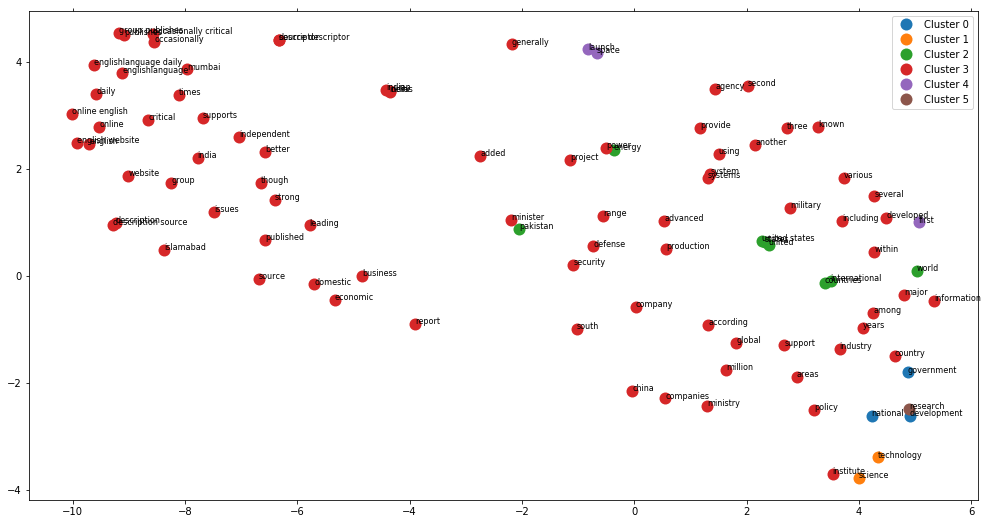

<Figure size 432x288 with 0 Axes>

In [ ]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
cvector_plot_clusters_terms = pd.DataFrame(dict(x=xs, y=ys, label=term_clusters, words = cvector_words)) 

#group by cluster
groups = cvector_plot_clusters_terms.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=term_cluster_names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the title
for i in range(len(cvector_plot_clusters_terms)):
    ax.text(cvector_plot_clusters_terms.loc[i]['x'], cvector_plot_clusters_terms.loc[i]['y'], cvector_plot_clusters_terms.iloc[i]['words'], size=8)  
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('term_clusters.png') 

### Hierarchical Term Clustering

In [ ]:
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster import AgglomerativeClustering

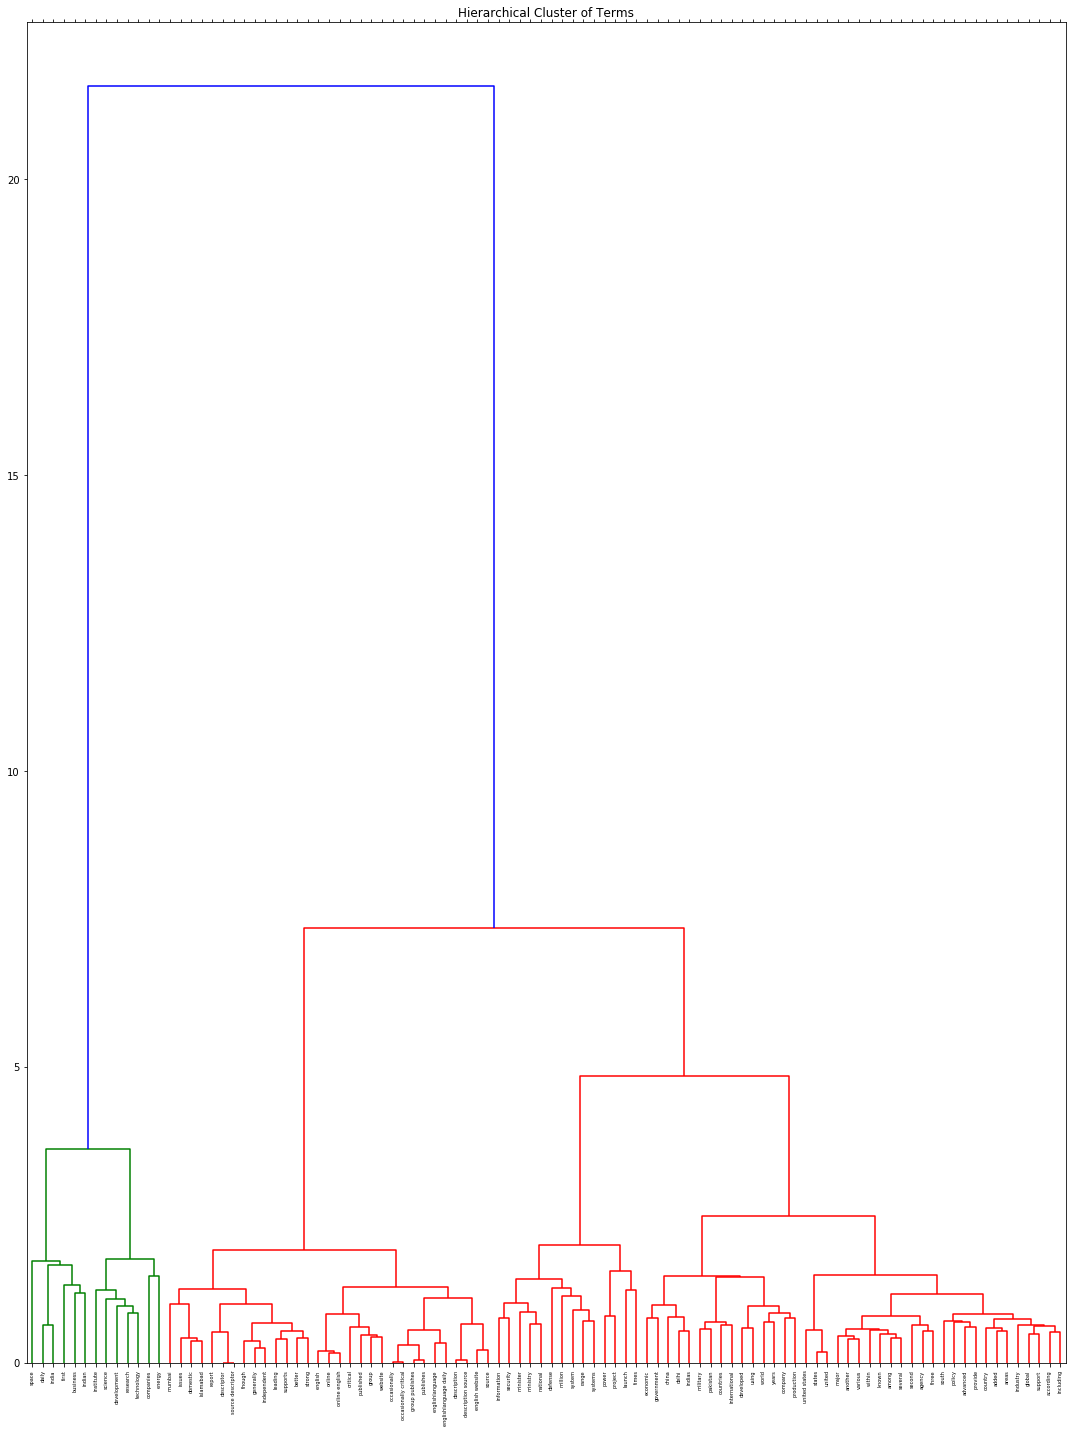

In [ ]:
linkage_matrix = ward(dist_terms) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="top", labels=words);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.title("Hierarchical Cluster of Terms")  
plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('term_hierarachy.png', dpi=200) #save figure as ward_clusters

In [ ]:
plt.close

<function matplotlib.pyplot.close>

In [ ]:
terms_agg_cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
terms_agg_cluster.fit_predict(dist_terms)

array([2, 3, 5, 0, 2, 0, 2, 1, 4, 5, 5, 5, 2, 2, 1, 1, 5, 3, 1, 1, 3, 2,
       2, 4, 4, 5, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1, 3, 3, 2, 2, 2,
       2, 1, 1, 0, 0, 4, 2, 2, 2, 5, 5, 1, 2, 1, 1, 1, 1, 5, 2, 5, 5, 5,
       0, 4, 1, 5, 4, 2, 2, 0, 5, 2, 4, 3, 5, 0, 0, 1, 2, 1, 0, 0, 2, 1,
       0, 1, 0, 0, 0, 2, 1, 2, 2, 2])

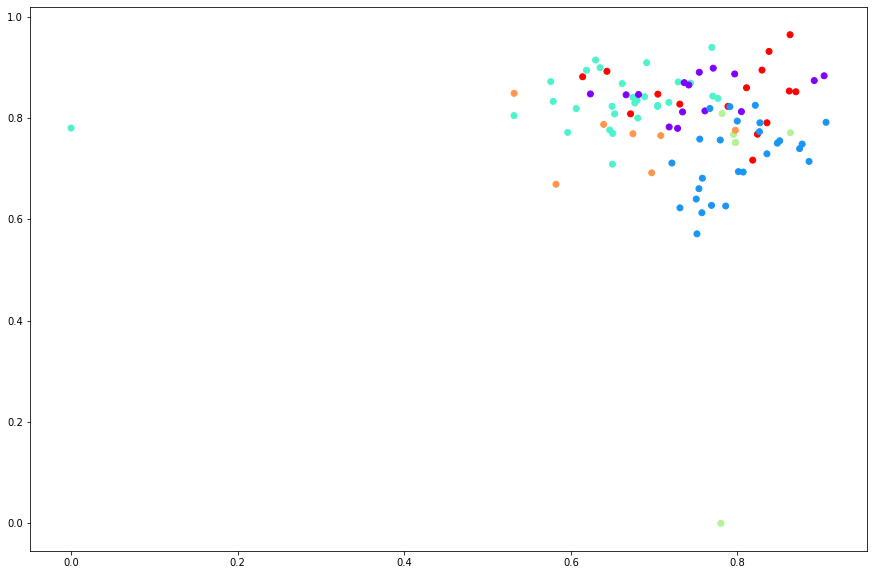

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(dist_terms[:,0], dist_terms[:,1], c=terms_agg_cluster.labels_, cmap='rainbow')

## Approach #2: TF-IDF

In [ ]:
# TF-IDF Vectorizer for entire model 

# tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
#                                  min_df=0.1, stop_words='english',
#                                  use_idf=True, tokenizer=tokenize_only, ngram_range=(1,2))


tfidfvector = TfidfVectorizer(min_df = 0.2, max_df = 0.8, ngram_range=(1,2), stop_words = STOPWORDS,
                              tokenizer = clean_doc, use_idf = True)

tfidfvector.fit_transform(body)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'hadnt', 'hasnt', 'havent', 'heres', 'mustnt', 'shant', 'shell', 'shouldnt', 'thats', 'theres', 'theyd', 'theyll', 'theyre', 'theyve', 'wasnt', 'werent', 'whats', 'whens', 'wheres', 'wouldnt', 'youll', 'youre', 'youve'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


<499x98 sparse matrix of type '<class 'numpy.float64'>'
	with 15318 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_matrix = tfidfvector.fit_transform(body) #fit the vectorizer to text in articles

tfidf_matrix.shape

(499, 98)

In [ ]:
len(tfidfvector.get_feature_names())

98

### Document-Term Matrix (TF-IDF)

In [ ]:
tfidf_array = tfidf_matrix.toarray()

In [ ]:
df_tfidfvector = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidfvector.get_feature_names())
df_tfidfvector.head(10)

according     added  advanced    agency  ...  website  within     world     years
0   0.183387  0.000000       0.0  0.000000  ...      0.0     0.0  0.000000  0.000000
1   0.000000  0.000000       0.0  0.000000  ...      0.0     0.0  0.000000  0.000000
2   0.107261  0.000000       0.0  0.107261  ...      0.0     0.0  0.000000  0.092852
3   0.000000  0.000000       0.0  0.000000  ...      0.0     0.0  0.000000  0.218561
4   0.068332  0.074583       0.0  0.000000  ...      0.0     0.0  0.134892  0.000000
5   0.000000  0.000000       0.0  0.000000  ...      0.0     0.0  0.000000  0.853959
6   0.000000  0.000000       0.0  0.000000  ...      0.0     0.0  0.000000  0.000000
7   0.116005  0.000000       0.0  0.000000  ...      0.0     0.0  0.114501  0.100421
8   0.000000  0.000000       0.0  0.000000  ...      0.0     0.0  0.000000  0.000000
9   0.000000  0.000000       0.0  0.000000  ...      0.0     0.0  0.000000  0.774478

[10 rows x 98 columns]

In [ ]:
tfidf_terms = tfidfvector.get_feature_names()
tfidf_terms[:20]

['according',
 'added',
 'advanced',
 'agency',
 'among',
 'another',
 'areas',
 'better',
 'business',
 'china',
 'companies',
 'company',
 'countries',
 'country',
 'critical',
 'daily',
 'defense',
 'delhi',
 'description',
 'description source']

### TD-IDF Ranking by Score Weight

In [ ]:
# sum tfidf frequency of each term through documents
sums = tfidf_matrix.sum(axis=0)

In [ ]:
# connecting term to its sums frequency
data = []
for col, term in enumerate(tfidf_terms):
    data.append( (term, sums[0,col] ))

In [ ]:
tfidf_ranking = pd.DataFrame(data, columns=['term','rank'])
tfidf_ranking.sort_values('rank', ascending=False)

term       rank
38                  india  58.505307
71               research  45.737830
86             technology  44.461231
79                  space  43.674446
61               pakistan  43.630060
..                    ...        ...
58  occasionally critical  10.773807
81                 strong  10.492307
37            independent  10.465854
31              generally  10.048201
87                 though   9.805168

[98 rows x 2 columns]

In [ ]:
# printing top 20 terms based on TF-IDF score

df_tfidfranking = tfidf_ranking.sort_values('rank', ascending = False).head(20)
df_tfidfranking

term       rank
38           india  58.505307
71        research  45.737830
86      technology  44.461231
79           space  43.674446
61        pakistan  43.630060
15           daily  41.588702
39          indian  39.961062
89           times  36.671537
30           first  36.400009
72         science  34.122118
48          launch  32.984284
26         english  30.746450
11         company  30.682727
52         million  29.718559
16         defense  29.445021
59          online  29.421724
33      government  28.501003
84          system  28.374651
60  online english  28.037013
65         project  27.802765

In [ ]:
# printing all terms by TF-IDF ranking
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(tfidf_ranking.sort_values('rank', ascending = False))

                     term       rank
38                  india  58.505307
71               research  45.737830
86             technology  44.461231
79                  space  43.674446
61               pakistan  43.630060
15                  daily  41.588702
39                 indian  39.961062
89                  times  36.671537
30                  first  36.400009
72                science  34.122118
48                 launch  32.984284
26                english  30.746450
11                company  30.682727
52                million  29.718559
16                defense  29.445021
59                 online  29.421724
33             government  28.501003
84                 system  28.374651
60         online english  28.037013
65                project  27.802765
22            development  27.250947
25                 energy  26.658059
63                  power  26.406041
24               economic  26.364422
85                systems  24.244422
74               security  24.088484
9

### Term Comparison (Approach 1 vs Approach 2)

Comparing ranks from approach 1 and 2

In [ ]:
print(df_cvranking,'\n')
print(df_tfidfranking)

           Term  Count
0         india   1460
1          will   1363
2    technology   1273
3      research   1152
4       science   1133
5          said   1095
6      pakistan    889
7           new    875
8         first    869
9       english    771
10        space    755
11   government    684
12        daily    683
13  development    665
14          url    658
15       indian    590
16          one    584
17       center    556
18         left    549
19          top    547 

              term       rank
38           india  58.505307
71        research  45.737830
86      technology  44.461231
79           space  43.674446
61        pakistan  43.630060
15           daily  41.588702
39          indian  39.961062
89           times  36.671537
30           first  36.400009
72         science  34.122118
48          launch  32.984284
26         english  30.746450
11         company  30.682727
52         million  29.718559
16         defense  29.445021
59          online  29.421724
33   

### Document Clustering

#### Determining Number of Clusters

In [ ]:
tfidf_kmeans = KMeans(n_clusters=6, init='k-means++', random_state=5)
tfidf_kmeans.fit(tfidf_matrix)
tfidf_kmeans.inertia_

307.79370480708354

Text(0, 0.5, 'Inertia')

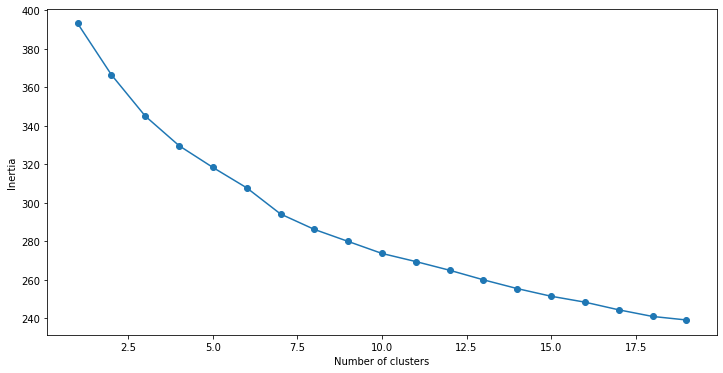

In [ ]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    tfidf_kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++', random_state=5)
    tfidf_kmeans.fit(tfidf_matrix)
    SSE.append(tfidf_kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
# k means using 5 clusters and k-means++ initialization
kmeans = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++', random_state=5)
kmeans.fit(tfidf_matrix)
pred = kmeans.predict(tfidf_matrix)

frame = pd.DataFrame(tfidf_matrix)
frame['cluster'] = pred
frame['cluster'].value_counts()

1    166
0    115
4     81
3     71
2     66
Name: cluster, dtype: int64

In [ ]:
frame

0  cluster
0      (0, 91)\t0.17701421853590352\n  (0, 9)\t0.14...        0
1      (0, 41)\t0.26076545313841526\n  (0, 73)\t0.2...        0
2      (0, 3)\t0.10726080848461683\n  (0, 54)\t0.45...        0
3      (0, 84)\t0.11435977965889497\n  (0, 31)\t0.1...        0
4      (0, 69)\t0.07514672468757184\n  (0, 38)\t0.0...        0
..                                                 ...      ...
494    (0, 61)\t0.05167543827744863\n  (0, 24)\t0.0...        0
495    (0, 51)\t0.3024369340764922\n  (0, 76)\t0.08...        0
496    (0, 51)\t0.14248506070490682\n  (0, 37)\t0.0...        0
497    (0, 57)\t0.03191385691806094\n  (0, 51)\t0.0...        3
498    (0, 83)\t0.03897188384386862\n  (0, 51)\t0.0...        3

[499 rows x 2 columns]

#### Summary of Documents by Cluster

In [ ]:
# creating variables to quickly filter documents in each cluster

cluster_0 = df.loc[frame['cluster'] == 0]
cluster_1 = df.loc[frame['cluster'] == 1]
cluster_2 = df.loc[frame['cluster'] == 2]
cluster_3 = df.loc[frame['cluster'] == 3]
cluster_4 = df.loc[frame['cluster'] == 4]

Filtering document with corresponding Topic and Title columns to get a general picture of contents

In [ ]:
cluster_0[['Topic', 'Title']].head(10)

Topic                                              Title
0   Proliferation  U.S. to unveil crackdown on counterfeit, pirat...
1              AI  Uber self-driving cars, with humans in control...
2          Energy  Germany to urge next Bolivian leaders to reviv...
3           Cyber  Don't Be Like Jeff Bezos. Here's How To Keep Y...
4          Health  Hospitals Around The World Have A Dire Shortag...
5            Tech  44,000-Year-Old Indonesian Cave Painting Is Re...
6          Health  Hope, Happiness And Social Connection: Hidden ...
7             Bio  Ready For Meat Grown From Animal Cells? A Star...
9           Space  Israel Aerospace to build Israel's next commun...
10             AI  Lidar laser-sensing technology: from self-driv...

In [ ]:
cluster_1[['Topic', 'Title']].head(10)

Topic                                              Title
24        Space  Indian Premier Space Agency ISRO To Design, De...
27  Aeronautics  Revision: Indian Researchers Develop Indigenou...
29      Nuclear  India: DRDO Successfully Test-Fires 'Indigenou...
36  Environment  India: Ministry of Earth Sciences Plans 'Deep ...
37      Weapons  India: Process Begins To Induct First Intercon...
38           AI  India's Nodal Planning Body NITI Aayog Present...
39        Space  Indian Premier Space Agency ISRO To Build 'Mor...
40        Space  India: ISRO To Transfer Lithium-ion Cell Techn...
44           AI  Indian Arm of Microsoft Develops Artificial In...
45        Cyber  India: National Informatics Center Says Hardwa...

In [ ]:
cluster_2[['Topic', 'Title']].head(10)

Topic                                              Title
11  Space  China launches gigantic telescope in hunt for ...
16  Space  China's next commercial rockets to make test f...
19  Space  Russia buries cosmonaut Alexei Leonov, first h...
25  Space  India: Space Agency Reports Progress in Develo...
30  Space  Indian Government Approves ISRO To Develop Sem...
32  Space  India: With Eye on China, Mauritius Seeks Help...
35  Space  India: Space Research Agency Creating 'Consort...
46  Space  India: ISRO Chief Says Space Agency Knows 'Exa...
54  Space  Pakistan To Launch 'Aggressive' Space Program ...
68  Space  Indian Daily Report: Space Agency's Successful...

In [ ]:
cluster_3[['Topic', 'Title']].head(10)

Topic                                              Title
8   Environment             2020 So Far: Fires, Floods, And Quakes
14  Environment  Deep-sea microbe sheds light on primordial evo...
17         Tech  Brexit hits UK science funding, deters interna...
21      Weapons  Indian Daily Reports About Short-Listed Ideas ...
28         Tech  India: Startups, IT Firms Showcase 'Emerging T...
34       Health  Israel, Britain sign scientific cooperation ag...
50         Chem  Nanocrystals Give MRI a New Shine - Chemistry ...
59         Tech  Danish minister: Great opportunities for learn...
75      Nuclear  Revision: India: Nuclear Research Centre Opera...
76          Bio  Generating Energy From Bacteria | Technion - I...

In [ ]:
cluster_4[['Topic', 'Title']].head(10)

Topic                                              Title
41  Weapons  Pakistan: Pak-Saudi naval exercise Naseem Al B...
42  Nuclear  Pakistan To Subscribe to IAEA Supplementary Gu...
43   Energy  Italian Government to Sign Contract for Acquir...
51   Energy  Pakistan: Caretaker Minister Witnesses Signing...
52   Energy  Pakistan Report: ECNEC Meeting Chaired by Prim...
53   Energy  Pakistan Report: ECNEC Approves Construction o...
60   Energy  Pakistan Report: First Hydroponic Unit at MNSU...
61  Weapons  Report: Pakistan Signs Aggrement with Turkish ...
62   Energy  Pakistan: Long-Awaited Mega Gas Pipeline TAPI ...
63   Energy  Pakistan to Import Liquefied Natural Gas, Petr...

#### Top Keywords

In [ ]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state=5)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

docs = { 'ID': ID, 'title': titles, 'source': sources, 'topic': topics, 'cluster': clusters, 'body': body }
docs_frame = pd.DataFrame(docs, index = [clusters] , columns = ['ID', 'title', 'cluster', 'topic'])
docs_frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

clusters_mini = MiniBatchKMeans(n_clusters=5, init_size=1024, batch_size=2048, random_state=5).fit_predict(tfidf_matrix)
# clusters = MiniBatchKMeans(n_clusters=4, random_state=20).fit_predict(cvector_matrix)

In [ ]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

In [ ]:
from __future__ import print_function

print("Top terms per cluster:")

get_top_keywords(tfidf_matrix, clusters_mini, tfidf_terms, 20)
print()

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

print("Top titles per cluster:")
print()
for i in range(num_clusters):
    # print("Cluster %d words:" % i, end='')
    
    # for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
    #     print(' %s' % vocab_frame.loc[cvector_terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    # print() #add whitespace
    # print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in docs_frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0
range,company,source,website,energy,technology,national,ministry,government,business,online,online english,project,defense,english,delhi,power,daily,india,indian

Cluster 1
online english,china,second,online,years,three,english,technology,indias,times,company,million,research,daily,agency,indian,first,india,launch,space

Cluster 2
publishes,group publishes,research,issues,indian,first,occasionally critical,occasionally,china,english,online,critical,online english,englishlanguage,launch,economic,mumbai,daily,times,india

Cluster 3
online,range,online english,china,project,description,description source,power,domestic,english,issues,security,countries,energy,minister,military,islamabad,defense,international,pakistan

Cluster 4
energy,systems,national,including,security,developed,world,years,information,using,institute,first,development,million,system,companies,company,science,technology,research

Top titles per cluster:

Cluster 0 titles: U.S. to unveil 

#### MDS with t-SNE

In [ ]:
dist = 1 - cosine_similarity(tfidf_matrix)

In [ ]:
tsne = TSNE(n_components=2, random_state=5)
tfidf_tsne = tsne.fit_transform(dist)
xs, ys = tfidf_tsne[:, 0], tfidf_tsne[:, 1]

#### Visualizing Document Clusters

In [ ]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
tfidf_plot_clusters = pd.DataFrame(dict(x=xs, y=ys, label=clusters, ID = ID))
tfidf_plot_clusters

x         y  label     ID
0    20.259914 -0.506937      0    1.0
1    16.301785 -1.473228      0    2.0
2    18.274389 -1.096460      0    3.0
3    13.405010  9.513788      0    4.0
4    11.849114  4.566719      0    5.0
..         ...       ...    ...    ...
494   8.244207  6.003483      0  500.0
495   1.592736  1.219164      0  501.0
496   0.833818  9.089537      0  502.0
497  22.487574  6.349585      3  503.0
498  20.940525  6.549381      3  504.0

[499 rows x 4 columns]

In [ ]:
# set up colors per clusters using a dict
cluster_colors = {0: '#ffff4d', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#1e9ba6', 5: '#8d1b9e'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3', 
                 4: 'Cluster 4'}

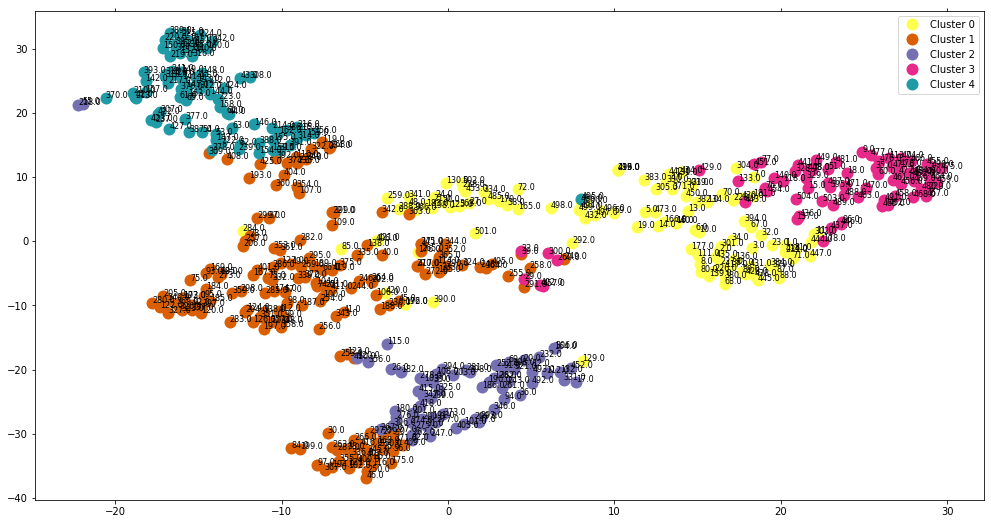

<Figure size 432x288 with 0 Axes>

In [ ]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
tfidf_plot_clusters = pd.DataFrame(dict(x=xs, y=ys, label=clusters, ID = ID)) 

#group by cluster
groups = tfidf_plot_clusters.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the title
for i in range(len(tfidf_plot_clusters)):
    ax.text(tfidf_plot_clusters.loc[i]['x'], tfidf_plot_clusters.loc[i]['y'], tfidf_plot_clusters.iloc[i]['ID'], size=8)  
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('tfidf_document_clusters.png') 

In [ ]:
plt.close()

### Term Clustering

In [ ]:
df_tfidf_transposed = df_tfidfvector.T
df_tfidf_terms = df_tfidf_transposed

In [ ]:
df_tfidf_terms.head()

0    1         2    3    ...       495       496       497       498
according  0.183387  0.0  0.107261  0.0  ...  0.151716  0.000000  0.029457  0.114210
added      0.000000  0.0  0.000000  0.0  ...  0.000000  0.000000  0.000000  0.000000
advanced   0.000000  0.0  0.000000  0.0  ...  0.000000  0.031442  0.097185  0.041867
agency     0.000000  0.0  0.107261  0.0  ...  0.000000  0.028591  0.000000  0.000000
among      0.202443  0.0  0.000000  0.0  ...  0.000000  0.031562  0.000000  0.084052

[5 rows x 499 columns]

In [ ]:
tfidf_words = df_tfidf_terms.index.tolist()

In [ ]:
km_terms = KMeans(n_clusters=6, init='k-means++', random_state=5)
km_terms.fit(df_tfidf_terms)
km_terms.inertia_

325.99547762319554

#### Determining Number of Clusters

Text(0, 0.5, 'Inertia')

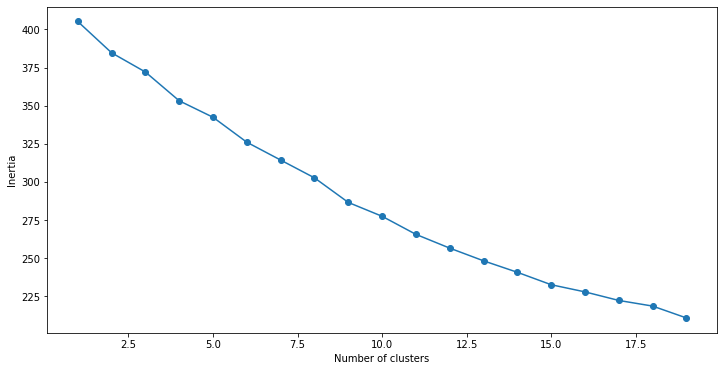

In [ ]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    km_terms = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++', random_state=5)
    km_terms.fit(df_tfidf_terms)
    SSE.append(km_terms.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

#### Summary of Terms by Cluster

In [ ]:
# k means using 5 clusters and k-means++ initialization
km_terms = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++', random_state=5)
km_terms.fit(df_tfidf_terms)
pred_terms = km_terms.predict(df_tfidf_terms)

frame = pd.DataFrame(df_tfidf_terms)
frame['cluster'] = pred_terms
frame['cluster'].value_counts()

2    83
0    12
4     1
3     1
1     1
Name: cluster, dtype: int64

In [ ]:
# creating variables to quickly filter documents in each cluster
cluster_0 = df_tfidf_terms.loc[frame['cluster'] == 0]
cluster_1 = df_tfidf_terms.loc[frame['cluster'] == 1]
cluster_2 = df_tfidf_terms.loc[frame['cluster'] == 2]
cluster_3 = df_tfidf_terms.loc[frame['cluster'] == 3]
cluster_4 = df_tfidf_terms.loc[frame['cluster'] == 4]

In [ ]:
print(cluster_0.index.values)

['business' 'companies' 'daily' 'development' 'energy' 'first' 'india'
 'indian' 'institute' 'research' 'science' 'technology']


In [ ]:
print(cluster_1.index.values)

['space']


In [ ]:
print(cluster_2.index.values)

['according' 'added' 'advanced' 'agency' 'among' 'another' 'areas'
 'better' 'china' 'countries' 'country' 'critical' 'defense' 'delhi'
 'description' 'description source' 'descriptor' 'developed' 'domestic'
 'economic' 'english' 'english website' 'englishlanguage'
 'englishlanguage daily' 'generally' 'global' 'government' 'group'
 'group publishes' 'including' 'independent' 'indias' 'industry'
 'information' 'international' 'islamabad' 'issues' 'known' 'launch'
 'leading' 'major' 'military' 'million' 'minister' 'ministry' 'mumbai'
 'national' 'occasionally' 'occasionally critical' 'online'
 'online english' 'policy' 'power' 'production' 'project' 'provide'
 'published' 'publishes' 'range' 'report' 'second' 'security' 'several'
 'source' 'source descriptor' 'south' 'states' 'strong' 'support'
 'supports' 'system' 'systems' 'though' 'three' 'times' 'united'
 'united states' 'using' 'various' 'website' 'within' 'world' 'years']


In [ ]:
print(cluster_3.index.values)

['company']


In [ ]:
print(cluster_4.index.values)

['pakistan']


#### MDS with t-SNE

In [ ]:
dist_terms = 1 - cosine_similarity(df_tfidf_terms)

tsne = TSNE(n_components=2, random_state=5)
tfidf_terms_tsne = tsne.fit_transform(dist_terms)
xs, ys = tfidf_terms_tsne[:, 0], tfidf_terms_tsne[:, 1]

#### Visualizing Term Clusters

In [ ]:
term_clusters = km_terms.labels_.tolist()

In [ ]:
#set up cluster names using a dict
term_cluster_names = {0: 'Cluster 0', 
                      1: 'Cluster 1', 
                      2: 'Cluster 2',
                      3: 'Cluster 3',
                      4: 'Cluster 4'}

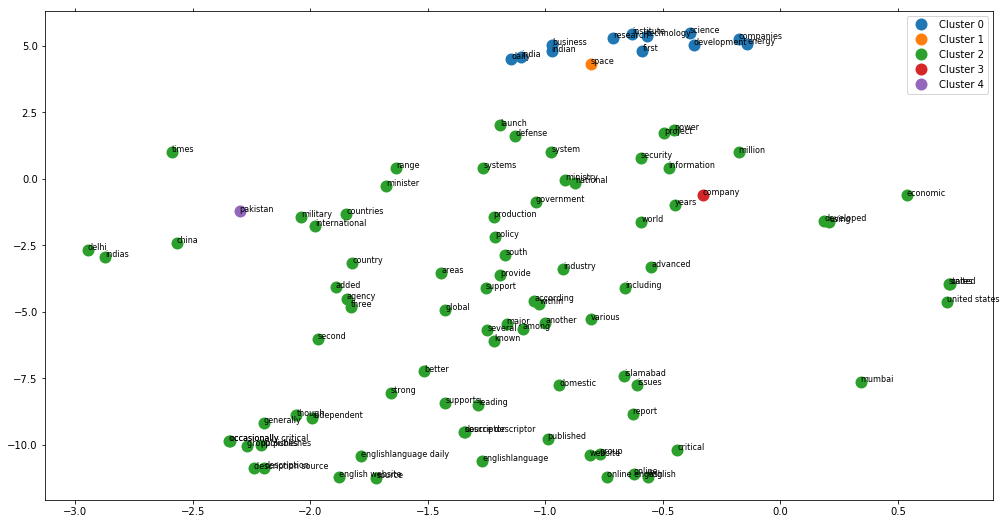

<Figure size 432x288 with 0 Axes>

In [ ]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
tfidf_plot_clusters_terms = pd.DataFrame(dict(x=xs, y=ys, label=term_clusters, words = tfidf_words)) 

#group by cluster
groups = tfidf_plot_clusters_terms.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=term_cluster_names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the title
for i in range(len(tfidf_plot_clusters_terms)):
    ax.text(tfidf_plot_clusters_terms.loc[i]['x'], tfidf_plot_clusters_terms.loc[i]['y'], tfidf_plot_clusters_terms.iloc[i]['words'], size=8)  
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('term_clusters.png') 

### Hierarchical Term Clustering

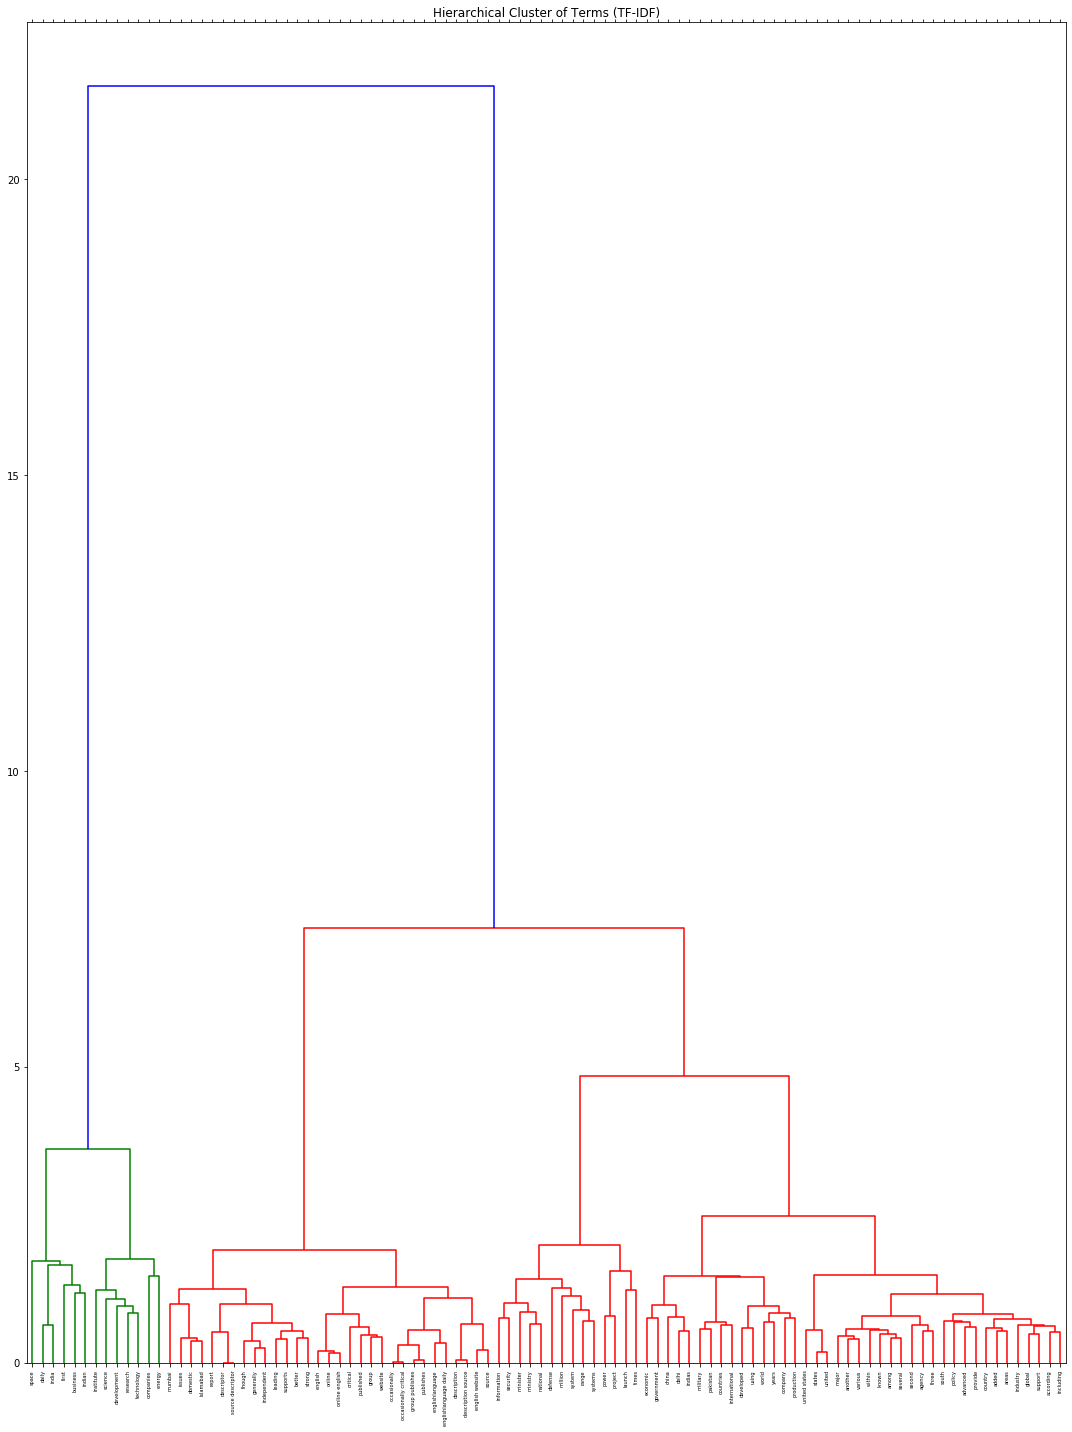

In [ ]:
linkage_matrix = ward(dist_terms) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="top", labels=words);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.title("Hierarchical Cluster of Terms (TF-IDF)")  
plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('tfidf_term_hierarachy.png', dpi=200) #save figure as ward_clusters

## Approach #3: Doc2vec

### Processing Corpus Text

In [ ]:
##############################
### Utility Functions 
##############################
# define list of codes to be dropped from document
# carriage-returns, line-feeds, tabs

codelist = ['\r', '\n', '\t']    

# text parsing function for entire document string
def parse_doc(text):
    text = text.lower()
    text = re.sub(r'&(.)+', "", text)  # no & references  
    text = re.sub(r'pct', 'percent', text)  # replace pct abreviation  
    text = re.sub(r"[^\w\d'\s]+", '', text)  # no punct except single quote 
    text = re.sub(r'[^\x00-\x7f]',r'', text)  # no non-ASCII strings    
    if text.isdigit(): text = ""  # omit words that are all digits    
    for code in codelist:
        text = re.sub(code, ' ', text)  # get rid of escape codes  
    # replace multiple spacess with one space
    text = re.sub('\s+', ' ', text)        
    return text

# text parsing for words within entire document string
# splits the document string into words/tokens
# parses the words and then recreates a document string
# returns list of parsed words/tokens and parsed document string
def parse_words(text): 
    # split document into individual words
    tokens=text.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out tokens that are one or two characters long
    tokens = [word for word in tokens if len(word) > 2]
    # filter out tokens that are more than twenty characters long
    tokens = [word for word in tokens if len(word) < 21]
    # filter out stop words if requested
    if DROP_STOPWORDS:
        tokens = [w for w in tokens if not w in stoplist]         
    # perform word stemming if requested
    if STEMMING:
        ps = PorterStemmer()
        tokens = [ps.stem(word) for word in tokens]
    # recreate the document string from parsed words
    text = ''
    for token in tokens:
        text = text + ' ' + token
    return tokens, text 


Function to process documents

In [ ]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    # stop_words = set(stopwords.words('english'))
    stop_words = STOPWORDS
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

In [ ]:
# #read in class corpus csv into python
# data=pd.read_csv('Class Corpus.csv')

#create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(df)):
    temp_text=df['Title'].iloc[i]
    titles.append(temp_text)
    
#create empty list to store text documents titles
topicslist=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(df)):
    temp_text=df['Topic'].iloc[i]
    topicslist.append(temp_text)

#create empty list to store text documents
text_body=[]

#for loop which appends the text to the text_body list
for i in range(0,len(df)):
    temp_text=df['Body'].iloc[i]
    text_body.append(temp_text)

#Note: the text_body is the unprocessed list of documents read directly form 
#the dataframe.
    
#empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

#Note: the processed_text is the PROCESSED list of documents read directly form 
#the csv.  Note the list of words is separated by commas.


#stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)

In [ ]:
final_processed_text

['washington reuters trump administration plans unveil efforts friday crack counterfeit pirated goods major ecommerce sites companies thirdparty sellers increase selfpolicing efforts acting department homeland security secretary white house adviser peter navarro among officials conference friday discuss effort national intellectual property rights coordination center arlington virginia administration officials thursday foreign sellers little prosecution administration official reuters strong government action necessary fundamentally realign incentive enforcement agencies planning identify counterfeit goods available statutory authorities pursue civil fines penalties according report reported street journal thursday confirmed administration official trump administration seeking legal authority explicitly permit government injunctive relief thirdparty marketplaces intermediaries dealing counterfeit official confirmed official companies adopt practices administration believes substantiall

In [ ]:
len(final_processed_text)

499

### Create TaggedDocument

In [ ]:
def clean_text(s):
    """
    clean the sentence for text processing: lowercase, punctuation
    :param s: input string
    :return: string
    """
    words = str(s).lower().split()
    return " ".join(words)

In [ ]:
# documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(list(df_new['title_l']))]
documents = [TaggedDocument(words=clean_text(s).split(), tags=[i]) for i, s in enumerate(final_processed_text)]
documents

[TaggedDocument(words=['washington', 'reuters', 'trump', 'administration', 'plans', 'unveil', 'efforts', 'friday', 'crack', 'counterfeit', 'pirated', 'goods', 'major', 'ecommerce', 'sites', 'companies', 'thirdparty', 'sellers', 'increase', 'selfpolicing', 'efforts', 'acting', 'department', 'homeland', 'security', 'secretary', 'white', 'house', 'adviser', 'peter', 'navarro', 'among', 'officials', 'conference', 'friday', 'discuss', 'effort', 'national', 'intellectual', 'property', 'rights', 'coordination', 'center', 'arlington', 'virginia', 'administration', 'officials', 'thursday', 'foreign', 'sellers', 'little', 'prosecution', 'administration', 'official', 'reuters', 'strong', 'government', 'action', 'necessary', 'fundamentally', 'realign', 'incentive', 'enforcement', 'agencies', 'planning', 'identify', 'counterfeit', 'goods', 'available', 'statutory', 'authorities', 'pursue', 'civil', 'fines', 'penalties', 'according', 'report', 'reported', 'street', 'journal', 'thursday', 'confirmed'

In [ ]:
len(documents)

499

### Training Model

In [ ]:
print('\nBegin Doc2Vec Work')
cores = multiprocessing.cpu_count()
print("\nNumber of processor cores:", cores)


Begin Doc2Vec Work

Number of processor cores: 2


In [ ]:
model_base = Doc2Vec(documents, vector_size = 1000, window = 2, min_count = 1, workers = cores)

### Document-Term Matrix (Doc2vec)

In [ ]:
# df_doc2vec = pd.DataFrame()
# for i in range(0,len(processed_text)):
#     vector=pd.DataFrame(model_base.infer_vector(processed_text[i])).transpose()
#     df_doc2vec=pd.concat([df_doc2vec,vector], axis=0)

df_doc2vec = pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model_base.infer_vector(processed_text[i])).T
    df_doc2vec=pd.concat([df_doc2vec,vector], axis = 0)

In [ ]:
df_doc2vec

0         1         2    ...       997       998       999
0   0.012893  0.147331  0.133620  ... -0.076667 -0.097843 -0.047132
0   0.003980  0.147112  0.121368  ... -0.072953 -0.107492 -0.034832
0  -0.001232  0.165754  0.130925  ... -0.075781 -0.118528 -0.035753
0   0.018905  0.233024  0.207431  ... -0.126534 -0.164695 -0.063086
0   0.003218  0.229555  0.184508  ... -0.112904 -0.163885 -0.054121
..       ...       ...       ...  ...       ...       ...       ...
0  -0.057446  0.347755  0.230347  ... -0.049591 -0.354791  0.036048
0  -0.000127  0.225404  0.184436  ... -0.093909 -0.162657 -0.043950
0  -0.062771  0.359239  0.209285  ... -0.116086 -0.348098  0.025739
0  -0.005329  0.338919  0.244857  ... -0.156663 -0.273503 -0.015927
0  -0.012560  0.330827  0.231141  ... -0.161533 -0.291000 -0.021517

[499 rows x 1000 columns]

In [ ]:
df_doc2vec=df_doc2vec.reset_index()

In [ ]:
df_doc2vec

index         0         1  ...       997       998       999
0        0  0.012893  0.147331  ... -0.076667 -0.097843 -0.047132
1        0  0.003980  0.147112  ... -0.072953 -0.107492 -0.034832
2        0 -0.001232  0.165754  ... -0.075781 -0.118528 -0.035753
3        0  0.018905  0.233024  ... -0.126534 -0.164695 -0.063086
4        0  0.003218  0.229555  ... -0.112904 -0.163885 -0.054121
..     ...       ...       ...  ...       ...       ...       ...
494      0 -0.057446  0.347755  ... -0.049591 -0.354791  0.036048
495      0 -0.000127  0.225404  ... -0.093909 -0.162657 -0.043950
496      0 -0.062771  0.359239  ... -0.116086 -0.348098  0.025739
497      0 -0.005329  0.338919  ... -0.156663 -0.273503 -0.015927
498      0 -0.012560  0.330827  ... -0.161533 -0.291000 -0.021517

[499 rows x 1001 columns]

In [ ]:
# doc_titles={'Title': titles}
# t=pd.DataFrame(doc_titles)

In [ ]:
# doc_topics={'Topic': topicslist}
# top=pd.DataFrame(doc_topics)

In [ ]:
# df_doc2vec=pd.concat([df_doc2vec,t, top], axis=1)

In [ ]:
df_doc2vec=df_doc2vec.drop('index', axis=1)

Newly formatted doc2vec matrix with document index

In [ ]:
df_doc2vec

0         1         2    ...       997       998       999
0    0.012893  0.147331  0.133620  ... -0.076667 -0.097843 -0.047132
1    0.003980  0.147112  0.121368  ... -0.072953 -0.107492 -0.034832
2   -0.001232  0.165754  0.130925  ... -0.075781 -0.118528 -0.035753
3    0.018905  0.233024  0.207431  ... -0.126534 -0.164695 -0.063086
4    0.003218  0.229555  0.184508  ... -0.112904 -0.163885 -0.054121
..        ...       ...       ...  ...       ...       ...       ...
494 -0.057446  0.347755  0.230347  ... -0.049591 -0.354791  0.036048
495 -0.000127  0.225404  0.184436  ... -0.093909 -0.162657 -0.043950
496 -0.062771  0.359239  0.209285  ... -0.116086 -0.348098  0.025739
497 -0.005329  0.338919  0.244857  ... -0.156663 -0.273503 -0.015927
498 -0.012560  0.330827  0.231141  ... -0.161533 -0.291000 -0.021517

[499 rows x 1000 columns]

In [ ]:
# df_doc2vec['Topic']

In [ ]:
# df_doc2vec.head(10)

In [ ]:
# Rearranging columns so it's easier to identify the specific document titles and topics in the matrix

# cols = list(df_doc2vec.columns)
# cols = [cols[-1]] + cols[:-1]
# df_doc2vec = df_doc2vec[cols]
# df_doc2vec.head()

In [ ]:
# cols = list(df_doc2vec.columns)
# cols = [cols[-1]] + cols[:-1]
# df_doc2vec = df_doc2vec[cols]
# df_doc2vec.head()

In [ ]:
# df_doc2vec.head()

### Document Clustering

#### Determining Number of Clusters

In [ ]:
d2v_kmeans = KMeans(n_clusters=6, init='k-means++', random_state=5)
d2v_kmeans.fit(df_doc2vec)
d2v_kmeans.inertia_

226.0844206156251

Text(0, 0.5, 'Inertia')

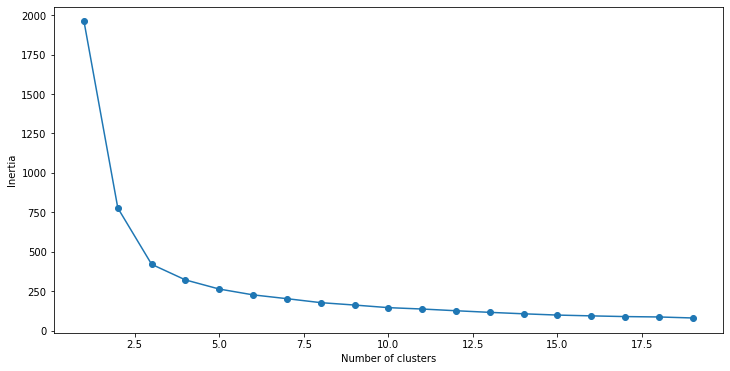

In [ ]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    d2v_kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++', random_state=5)
    d2v_kmeans.fit(df_doc2vec)
    SSE.append(d2v_kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
# k means using 5 clusters and k-means++ initialization
kmeans = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++', random_state=5)
kmeans.fit(df_doc2vec)
d2v_clusters = kmeans.labels_.tolist()
pred = kmeans.predict(df_doc2vec)

frame = pd.DataFrame(df_doc2vec)
frame['cluster'] = pred
frame['cluster'].value_counts()

2    198
3    150
0    106
4     32
1     13
Name: cluster, dtype: int64

#### Summary of Documents by Cluster

In [ ]:
# creating variables to quickly filter documents in each cluster

cluster_0 = df.loc[frame['cluster'] == 0]
cluster_1 = df.loc[frame['cluster'] == 1]
cluster_2 = df.loc[frame['cluster'] == 2]
cluster_3 = df.loc[frame['cluster'] == 3]
cluster_4 = df.loc[frame['cluster'] == 4]

Filtering document with corresponding Topic and Title columns to get a general picture of contents

In [ ]:
cluster_0[['Topic', 'Title']].head(10)

Topic                                              Title
2        Energy  Germany to urge next Bolivian leaders to reviv...
3         Cyber  Don't Be Like Jeff Bezos. Here's How To Keep Y...
4        Health  Hospitals Around The World Have A Dire Shortag...
5          Tech  44,000-Year-Old Indonesian Cave Painting Is Re...
6        Health  Hope, Happiness And Social Connection: Hidden ...
7           Bio  Ready For Meat Grown From Animal Cells? A Star...
10           AI  Lidar laser-sensing technology: from self-driv...
14  Environment  Deep-sea microbe sheds light on primordial evo...
33  Aeronautics  F-35 maker Lockheed Martin to open Jerusalem p...
44           AI  Indian Arm of Microsoft Develops Artificial In...

In [ ]:
cluster_1[['Topic', 'Title']].head(10)

Topic                                        Title
453   Tech             Science and technology in Israel
454   Tech               Science and technology in Iran
455   Tech           Science and technology in Pakistan
457   Tech  Science and technology in the United States
471   Tech            History of science and technology
472   Tech    Science and technology in the Philippines
482   Chem                         Chemical engineering
486  Space                                    Satellite
487  Space                                  Spaceflight
488   Chem                Chemical weapon proliferation

In [ ]:
cluster_2[['Topic', 'Title']].head(10)

Topic                                              Title
0   Proliferation  U.S. to unveil crackdown on counterfeit, pirat...
1              AI  Uber self-driving cars, with humans in control...
12             AI  How VR helps kids with autism make sense of re...
17           Tech  Brexit hits UK science funding, deters interna...
21        Weapons  Indian Daily Reports About Short-Listed Ideas ...
22          Cyber  Israel earmarks $24 million for new program to...
25          Space  India: Space Agency Reports Progress in Develo...
26        Weapons  India: Bhabha Atomic Research Center Develop M...
28           Tech  India: Startups, IT Firms Showcase 'Emerging T...
29        Nuclear  India: DRDO Successfully Test-Fires 'Indigenou...

In [ ]:
cluster_3[['Topic', 'Title']].head(10)

Topic                                              Title
8   Environment             2020 So Far: Fires, Floods, And Quakes
9         Space  Israel Aerospace to build Israel's next commun...
11        Space  China launches gigantic telescope in hunt for ...
13        Space  Fly me to the moon: Japanese billionaire Maeza...
15      Weapons  German WW2 U-boat base in France reboots as da...
16        Space  China's next commercial rockets to make test f...
18        Space  Japan to participate in U.S. moon landing plan...
19        Space  Russia buries cosmonaut Alexei Leonov, first h...
20      Weapons  India: Indigenous Light Combat Aircraft Succes...
23      Weapons  India: Defense Acquisition Council Clears Proc...

In [ ]:
cluster_4[['Topic', 'Title']].head(10)

Topic                                              Title
161  Chem  The Peculiar Chronology of Persistent Nerve Ag...
449  Tech                     Science and technology studies
450  Tech                    Science and technology in China
451  Tech                    Science and technology in India
452  Tech              Science and technology in South Korea
456  Tech                   Science and technology in Russia
458  Tech                   Science and technology in Brazil
460  Tech                   Science and technology in Canada
461  Tech                    Science and technology in Japan
462  Tech                Science and technology in Argentina

#### MDS with t-SNE

In [ ]:
dist = 1 - cosine_similarity(df_doc2vec)

In [ ]:
tsne = TSNE(n_components=2, random_state=5)
d2v_tsne = tsne.fit_transform(dist)
xs, ys = d2v_tsne[:, 0], d2v_tsne[:, 1]

#### Visualizing Document Clusters

In [ ]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
d2v_plot_clusters = pd.DataFrame(dict(x=xs, y=ys, label=d2v_clusters, ID = ID))
d2v_plot_clusters

x          y  label     ID
0    33.286209   3.821254      2    1.0
1    30.412895   0.642061      2    2.0
2   -22.235041  10.415513      0    3.0
3   -21.895462  17.947418      0    4.0
4   -21.804209  12.116297      0    5.0
..         ...        ...    ...    ...
494 -16.015486   5.086721      1  500.0
495 -21.842520  10.116271      0  501.0
496 -16.003941   6.718842      1  502.0
497  29.405348  -5.527560      4  503.0
498  29.536238  -5.649020      4  504.0

[499 rows x 4 columns]

In [ ]:
# set up colors per clusters using a dict
cluster_colors = {0: '#ffff4d', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#1e9ba6', 5: '#8d1b9e'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3', 
                 4: 'Cluster 4'}

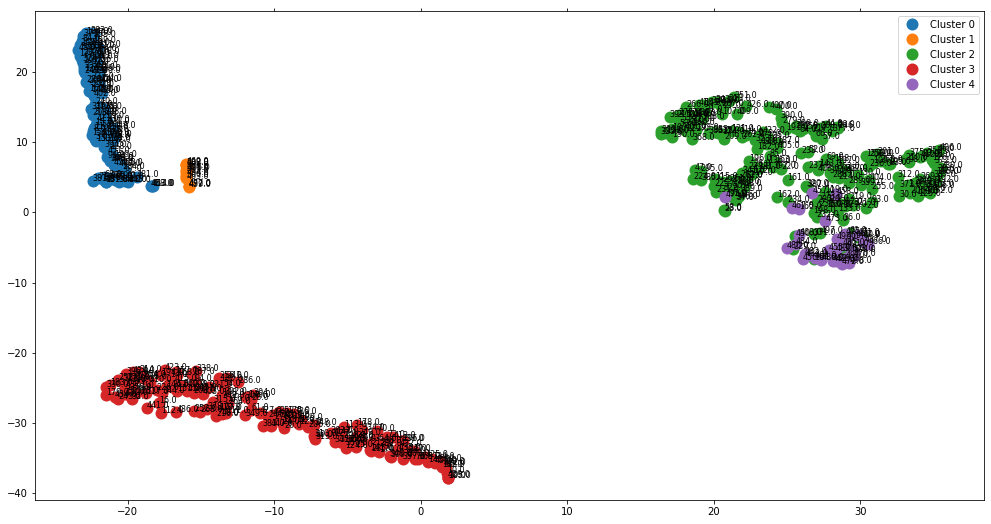

<Figure size 432x288 with 0 Axes>

In [ ]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
d2v_plot_clusters = pd.DataFrame(dict(x=xs, y=ys, label=d2v_clusters, ID = ID))

#group by cluster
groups = d2v_plot_clusters.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the title
for i in range(len(d2v_plot_clusters)):
    ax.text(d2v_plot_clusters.loc[i]['x'], d2v_plot_clusters.loc[i]['y'], d2v_plot_clusters.iloc[i]['ID'], size=8)  
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('d2v_doc_clusters.png') 

In [ ]:
plt.close()